In [1]:
from EmuLP import Cosmology, Filter, Galaxy, Estimator, Extinction, Template, Analysis

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax_cosmo as jc
import jax.numpy as jnp
from jax import vmap, jit
import json, pickle
import os,sys,copy
from tqdm import tqdm
from collections import namedtuple

from scipy.interpolate import interp1d
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline as j_spline

2023-12-22 15:23:42.108867: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/nvptx_compiler.cc:497] The NVIDIA driver's CUDA version is 11.3 which is older than the ptxas CUDA version (11.4.152). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
os.getcwd()

'/sps/lsst/groups/photoz/jocheval/PhotoZ_PhD'

In [3]:
#ref_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-togglePriorTrue-opa-fullAnalysis.json' # attention à la localisation du fichier !
#ref_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-prior-full-KinCalClusTemp_priorEBV_noTypeNoLaw.json'
#test_conf_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-prior-full-KinCalClusTemp_priorEBV_noTypeNoLaw.json'
test_conf_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-prior-full-KinCalClusTempNoAVG_priorEBV_noTypeNoLaw.json' # attention à la localisation du fichier !
#conf_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-prior-full-dustSelTemp_priorEBV.json' # attention à la localisation du fichier !

In [4]:
test_conf_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-prior-full-dustyTemp5_noEBV.json'
test_conf_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-prior-full-DustSelTemp_v7.2.json'
ref_json = 'EmuLP/COSMOS2020-with-CWW-HSC_only-jax-CC-priorNzEBV-full.json'

In [5]:
#test_conf_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-prior-full-DSPS_tempV1.json'
#ref_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-prior-full-KinCalClusTempNoAVG_priorEBV_noTypeNoLaw.json'

In [6]:
ref_inputs = Analysis.json_to_inputs(ref_json)
test_inputs = Analysis.json_to_inputs(test_conf_json)

In [7]:
os.getcwd()

'/sps/lsst/groups/photoz/jocheval/PhotoZ_PhD'

In [8]:
cosmo_ref, z_grid_ref, fine_z_grid_ref, wl_grid_ref, filters_arr_ref, named_filts_ref, baseTemp_arr_ref, extlaws_dict_ref,\
ebv_vals_ref, dust_arr_ref, wls_opa_ref, opa_zgrid_ref, opacity_grid_ref, obs_arr_ref = Analysis.load_data_for_analysis(os.path.basename(ref_json))

Loading filters :


100%|██████████| 7/7 [00:00<00:00, 62.09it/s]


Building templates :


100%|██████████| 62/62 [00:02<00:00, 24.08it/s]


Generating dust attenuations laws :


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Loading IGM attenuations :
Loading observations :


100%|██████████| 1000/1000 [00:00<00:00, 1149.35it/s]


In [9]:
cosmo_test, z_grid_test, fine_z_grid_test, wl_grid_test, filters_arr_test, named_filts_test, baseTemp_arr_test, extlaws_dict_test,\
ebv_vals_test, dust_arr_test, wls_opa_test, opa_zgrid_test, opacity_grid_test, obs_arr_test = Analysis.load_data_for_analysis(os.path.basename(test_conf_json))

Loading filters :


100%|██████████| 7/7 [00:00<00:00, 77.66it/s]


Building templates :


100%|██████████| 48/48 [00:10<00:00,  4.62it/s]


Generating dust attenuations laws :


100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Loading IGM attenuations :
Loading observations :


100%|██████████| 1000/1000 [00:00<00:00, 1287.54it/s]


In [10]:
os.getcwd()

'/sps/lsst/groups/photoz/jocheval/PhotoZ_PhD'

In [11]:
df_ref_emulp = pd.read_pickle(f"{ref_inputs['run name']}_results_summary.pkl")
df_ref_emulp

Id  Photometric redshift  True redshift        Template SED  \
0      362.0                  0.45         0.6636   Scd_cww_resample9   
1     8353.0                  0.41         0.2819  Sbc_cww_resample11   
2     7547.0                  0.21         0.2215   Scd_cww_resample8   
3    10402.0                  0.61         0.6595   Scd_cww_resample0   
4    12425.0                  1.91         1.0201   Sbc_cww_resample1   
..       ...                   ...            ...                 ...   
995   5756.0                  2.89         2.6639    Im_cww_resample5   
996  16455.0                  0.67         0.7336    El_cww_resample1   
997  13692.0                  0.75         0.9258   Scd_cww_resample1   
998   3751.0                  0.75         0.8700   Scd_cww_resample2   
999   1602.0                  1.01         1.1173   Scd_cww_resample8   

    Extinction law  E(B-V)        Chi2  Highest evidence SED  \
0         Calzetti     0.0   47.006870     Scd_cww_resample9   
1         Calzetti     0.0  229.159592  SB2_total2_resample0   
2         Calzetti     0.0  193.463196     Scd_cww_resample8   
3         Calzetti     0.0   26.461437     Scd_cww_resample0   
4         Calzetti     0.0   26.649300     Sbc_cww_resample1   
..             ...     ...         ...                   ...   
995       Calzetti     0.0   27.969521      Im_cww_resample4   
996       Calzetti     0.0   10.991859      El_cww_resample1   
997       Calzetti     0.0   73.460190     Scd_cww_resample1   
998       Calzetti     0.0   59.368866     Scd_cww_resample2   
999       Calzetti     0.0   57.782326     Scd_cww_resample8   

    Highest evidence dust law  Highest evidence E(B-V)  \
0                    Calzetti                      0.0   
1                    Calzetti                      0.0   
2                    Calzetti                      0.0   
3                    Calzetti                      0.0   
4                    Calzetti                      0.0   
..                        ...                      ...   
995                  Calzetti                      0.0   
996                  Calzetti                      0.0   
997                  Calzetti                      0.0   
998                  Calzetti                      0.0   
999                  Calzetti                      0.0   

     Highest evidence odd ratio  Highest evidence z_phot (mode)  \
0                      1.000000                            0.45   
1                           NaN                            3.01   
2                      1.000000                            0.21   
3                      1.000000                            0.61   
4                      1.000000                            1.91   
..                          ...                             ...   
995                    1.034162                            2.89   
996                    1.000000                            0.67   
997                    1.000000                            0.75   
998                    1.000000                            0.75   
999                    1.000000                            1.01   

     Highest evidence z_phot (mean)  Highest evidence sigma(z)  \
0                          0.451961                   0.000156   
1                               NaN                        NaN   
2                          0.207015                   0.000074   
3                          0.613223                   0.000434   
4                          1.917085                   0.000823   
..                              ...                        ...   
995                        2.877169                   0.016031   
996                        0.674118                   0.000066   
997                        0.758495                   0.000121   
998                        0.747711                   0.000100   
999                        1.000205                   0.000538   

       Best SED at z_spec Best dust law at z_spec  E(B-V) at z_spec  

In [12]:
df_test_emulp = pd.read_pickle(f"{test_inputs['run name']}_results_summary.pkl")
df_test_emulp

Id  Photometric redshift  True redshift  \
0      362.0                  0.53         0.6636   
1     8353.0                  0.29         0.2819   
2     7547.0                  0.23         0.2215   
3    10402.0                  0.61         0.6595   
4    12425.0                  1.35         1.0201   
..       ...                   ...            ...   
995   5756.0                  0.17         2.6639   
996  16455.0                  0.73         0.7336   
997  13692.0                  0.65         0.9258   
998   3751.0                  0.73         0.8700   
999   1602.0                  1.01         1.1173   

                          Template SED Extinction law  E(B-V)        Chi2  \
0     AVG_Irr_Calzetti_EBV0.021_noDust         Prevot     0.1   69.215149   
1       AVG_Sbc_Prevot_EBV0.145_noDust         Prevot     0.1  153.103439   
2       AVG_Irr_Prevot_EBV0.145_noDust         Prevot     0.2   72.629799   
3     AVG_Scd_Calzetti_EBV0.228_noDust         Prevot     0.2   16.685595   
4    AVG_E-S0_Calzetti_EBV0.228_noDust         Prevot     0.2   23.405758   
..                                 ...            ...     ...         ...   
995     AVG_Irr_Prevot_EBV0.145_noDust         Prevot     0.1   26.121231   
996    AVG_E-S0_Prevot_EBV0.103_noDust       Calzetti     0.1    6.015019   
997   AVG_Scd_Calzetti_EBV0.062_noDust         Prevot     0.2   22.773232   
998     AVG_Sbc_Prevot_EBV0.269_noDust         Prevot     0.1   38.833015   
999     AVG_Scd_Prevot_EBV0.186_noDust         Prevot     0.1   22.828465   

                  Highest evidence SED Highest evidence dust law  \
0     AVG_Irr_Calzetti_EBV0.021_noDust                    Prevot   
1       AVG_Sbc_Prevot_EBV0.145_noDust                    Prevot   
2       AVG_Irr_Prevot_EBV0.145_noDust                    Prevot   
3     AVG_Scd_Calzetti_EBV0.228_noDust                    Prevot   
4    AVG_E-S0_Calzetti_EBV0.228_noDust                    Prevot   
..                                 ...                       ...   
995   AVG_Irr_Calzetti_EBV0.062_noDust                    Prevot   
996    AVG_E-S0_Prevot_EBV0.062_noDust                  Calzetti   
997   AVG_Scd_Calzetti_EBV0.062_noDust                    Prevot   
998     AVG_Scd_Prevot_EBV0.186_noDust                    Prevot   
999     AVG_Scd_Prevot_EBV0.186_noDust                    Prevot   

     Highest evidence E(B-V)  Highest evidence odd ratio  \
0                        0.1                    1.000000   
1                        0.1                    1.000000   
2                        0.2                    1.000000   
3                        0.2                    1.000000   
4                        0.2                    1.000000   
..                       ...                         ...   
995                      0.1                    1.659939   
996                      0.1                    1.217816   
997                      0.2                    1.000000   
998                      0.2                    2.101376   
999                      0.1                    1.000000   

     Highest evidence z_phot (mode)  Highest evidence z_phot (mean)  \
0                              0.53                        0.537294   
1                              0.29                        0.285286   
2                              0.23                        0.227985   
3                              0.61                        0.606673   
4                              1.35                        1.346262   
..                              ...                             ...   
995                            2.51                        2.480472   
996                            0.73                        0.720937   
997                            0.65                        0.651641   
998                            0.83                        0.822054   
999                            1.01                        1.013005   

     Highest evidence sigma(z)                Best SED at

In [13]:
df_ref_more, outl_rate_ref, NMAD_ref = Analysis.results_in_dataframe(ref_json, obs_arr_ref, named_filts_ref)
df_ref_more

100%|██████████| 1000/1000 [00:20<00:00, 49.16it/s]


Outlier rate = 8.7174% ; NMAD = 0.04860


Id  Photometric redshift  True redshift        Template SED  \
0      362.0                  0.45         0.6636   Scd_cww_resample9   
1     8353.0                  0.41         0.2819  Sbc_cww_resample11   
2     7547.0                  0.21         0.2215   Scd_cww_resample8   
3    10402.0                  0.61         0.6595   Scd_cww_resample0   
4    12425.0                  1.91         1.0201   Sbc_cww_resample1   
..       ...                   ...            ...                 ...   
995   5756.0                  2.89         2.6639    Im_cww_resample5   
996  16455.0                  0.67         0.7336    El_cww_resample1   
997  13692.0                  0.75         0.9258   Scd_cww_resample1   
998   3751.0                  0.75         0.8700   Scd_cww_resample2   
999   1602.0                  1.01         1.1173   Scd_cww_resample8   

    Extinction law  E(B-V)        Chi2  Highest evidence SED  \
0         Calzetti     0.0   47.006870     Scd_cww_resample9   
1         Calzetti     0.0  229.159592  SB2_total2_resample0   
2         Calzetti     0.0  193.463196     Scd_cww_resample8   
3         Calzetti     0.0   26.461437     Scd_cww_resample0   
4         Calzetti     0.0   26.649300     Sbc_cww_resample1   
..             ...     ...         ...                   ...   
995       Calzetti     0.0   27.969521      Im_cww_resample4   
996       Calzetti     0.0   10.991859      El_cww_resample1   
997       Calzetti     0.0   73.460190     Scd_cww_resample1   
998       Calzetti     0.0   59.368866     Scd_cww_resample2   
999       Calzetti     0.0   57.782326     Scd_cww_resample8   

    Highest evidence dust law  Highest evidence E(B-V)  ...  MagAB(hsc_iHSC)  \
0                    Calzetti                      0.0  ...        21.724495   
1                    Calzetti                      0.0  ...        19.593529   
2                    Calzetti                      0.0  ...        20.448967   
3                    Calzetti                      0.0  ...        22.066360   
4                    Calzetti                      0.0  ...        23.027916   
..                        ...                      ...  ...              ...   
995                  Calzetti                      0.0  ...        23.831917   
996                  Calzetti                      0.0  ...        20.603783   
997                  Calzetti                      0.0  ...        21.630302   
998                  Calzetti                      0.0  ...        21.752357   
999                  Calzetti                      0.0  ...        22.431557   

     err_MagAB(hsc_iHSC)  MagAB(hsc_zHSC)  err_MagAB(hsc_zHSC)  \
0               0.005330        21.681114             0.006234   
1               0.002292        19.379829             0.002413   
2               0.003380        20.397652             0.003857   
3               0.007630        21.858215             0.008252   
4               0.011093        22.694069             0.011409   
..                   ...              ...                  ...   
995             0.014877        23.791687             0.019078   
996             0.003643        20.173088             0.003468   
997             0.005108        21.311661             0.005163   
998             0.005474        21.451469             0.005597   
999             0.007169        22.034317             0.007080   

    MagAB(hsc_yHSC) err_MagAB(hsc_yHSC)    Bias  Outlier       U-B       R-I  
0         21.581612            0.007518 -0.2136    False  0.455261  0.429222  
1         19.226929            0.002557  0.1281    False  0.858223  0.419388  
2         20.312340            0.004316 -0.0115    False  0.732582  0.199509  
3         21.678215            0.009633 -0.0495    False  0.587463  0.611992  
4         22.185799            0.011367  0.8899     True  0.492928  0.423218  
..              ...                 ...     ...      ...       ...       ...  
995       23.761284            0.029802  0.2261    False 

In [14]:
df_test_more, outl_rate_test, NMAD_test = Analysis.results_in_dataframe(test_conf_json, obs_arr_test, named_filts_test)
df_test_more

100%|██████████| 1000/1000 [00:19<00:00, 51.51it/s]

Outlier rate = 12.8257% ; NMAD = 0.07578


Id  Photometric redshift  True redshift  \
0      362.0                  0.53         0.6636   
1     8353.0                  0.29         0.2819   
2     7547.0                  0.23         0.2215   
3    10402.0                  0.61         0.6595   
4    12425.0                  1.35         1.0201   
..       ...                   ...            ...   
995   5756.0                  0.17         2.6639   
996  16455.0                  0.73         0.7336   
997  13692.0                  0.65         0.9258   
998   3751.0                  0.73         0.8700   
999   1602.0                  1.01         1.1173   

                          Template SED Extinction law  E(B-V)        Chi2  \
0     AVG_Irr_Calzetti_EBV0.021_noDust         Prevot     0.1   69.215149   
1       AVG_Sbc_Prevot_EBV0.145_noDust         Prevot     0.1  153.103439   
2       AVG_Irr_Prevot_EBV0.145_noDust         Prevot     0.2   72.629799   
3     AVG_Scd_Calzetti_EBV0.228_noDust         Prevot     0.2   16.685595   
4    AVG_E-S0_Calzetti_EBV0.228_noDust         Prevot     0.2   23.405758   
..                                 ...            ...     ...         ...   
995     AVG_Irr_Prevot_EBV0.145_noDust         Prevot     0.1   26.121231   
996    AVG_E-S0_Prevot_EBV0.103_noDust       Calzetti     0.1    6.015019   
997   AVG_Scd_Calzetti_EBV0.062_noDust         Prevot     0.2   22.773232   
998     AVG_Sbc_Prevot_EBV0.269_noDust         Prevot     0.1   38.833015   
999     AVG_Scd_Prevot_EBV0.186_noDust         Prevot     0.1   22.828465   

                  Highest evidence SED Highest evidence dust law  \
0     AVG_Irr_Calzetti_EBV0.021_noDust                    Prevot   
1       AVG_Sbc_Prevot_EBV0.145_noDust                    Prevot   
2       AVG_Irr_Prevot_EBV0.145_noDust                    Prevot   
3     AVG_Scd_Calzetti_EBV0.228_noDust                    Prevot   
4    AVG_E-S0_Calzetti_EBV0.228_noDust                    Prevot   
..                                 ...                       ...   
995   AVG_Irr_Calzetti_EBV0.062_noDust                    Prevot   
996    AVG_E-S0_Prevot_EBV0.062_noDust                  Calzetti   
997   AVG_Scd_Calzetti_EBV0.062_noDust                    Prevot   
998     AVG_Scd_Prevot_EBV0.186_noDust                    Prevot   
999     AVG_Scd_Prevot_EBV0.186_noDust                    Prevot   

     Highest evidence E(B-V)  ...  MagAB(hsc_iHSC)  err_MagAB(hsc_iHSC)  \
0                        0.1  ...        21.724495             0.005330   
1                        0.1  ...        19.593529             0.002292   
2                        0.2  ...        20.448967             0.003380   
3                        0.2  ...        22.066360             0.007630   
4                        0.2  ...        23.027916             0.011093   
..                       ...  ...              ...                  ...   
995                      0.1  ...        23.831917             0.014877   
996                      0.1  ...        20.603783             0.003643   
997                      0.2  ...        21.630302             0.005108   
998                      0.2  ...        21.752357             0.005474   
999                      0.1  ...        22.431557             0.007169   

     MagAB(hsc_zHSC)  err_MagAB(hsc_zHSC) MagAB(hsc_yHSC) err_MagAB(hsc_yHSC)  \
0          21.681114             0.006234       21.581612            0.007518   
1          19.379829             0.002413       19.226929            0.002557   
2          20.397652             0.003857       20.312340            0.004316   
3          21.858215             0.008252       21.678215            0.009633   
4          22.694069             0.011409       22.185799            0.011367   
..               ...                  ...             ...                 ...   
995        23.791687             0.019078       23.761284            0.029802   
996        20.173088             0.003468       19.879967            0.003540   
9

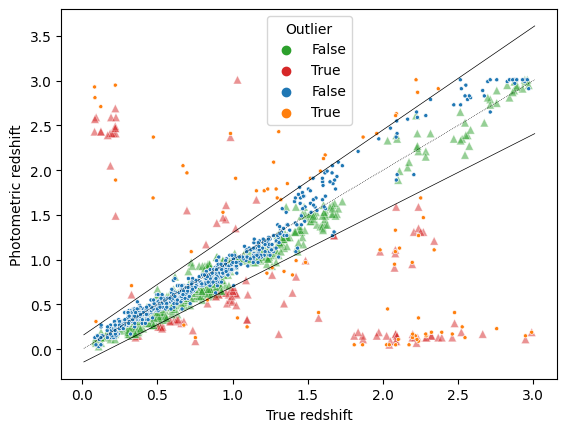

In [15]:
f,a=plt.subplots(1,1)
sns.scatterplot(data=df_test_more, x='True redshift', y='Photometric redshift', hue='Outlier', marker='^', alpha=0.5,\
                palette={True:'tab:red', False:'tab:green'}, ax=a)
sns.scatterplot(data=df_ref_more, x='True redshift', y='Photometric redshift', hue='Outlier', marker='.', ax=a)
a.plot(z_grid_ref, z_grid_ref, c='k', ls=':', lw=0.5)
a.plot(z_grid_ref, 0.15+1.15*z_grid_ref, c='k', lw=0.5)
a.plot(z_grid_ref, -0.15+0.85*z_grid_ref, c='k', lw=0.5)

In [16]:
with open(f"{ref_inputs['run name']}_posteriors_dict.pkl", 'rb') as handle:
    posteriors_dict_ref=pickle.load(handle)
with open(f"{test_inputs['run name']}_posteriors_dict.pkl", 'rb') as handle:
    posteriors_dict_test=pickle.load(handle)

In [17]:
_sel = (np.abs(df_test_more['Bias']) < np.abs(df_ref_more['Bias']))
sel_ref_df = df_ref_more[_sel]
sel_test_df = df_test_more[_sel]
sel_test_df

Id  Photometric redshift  True redshift  \
0      362.0                  0.53         0.6636   
1     8353.0                  0.29         0.2819   
2     7547.0                  0.23         0.2215   
4    12425.0                  1.35         1.0201   
10    4477.0                  0.19         0.2192   
..       ...                   ...            ...   
990  11291.0                  2.91         2.9290   
991  16400.0                  1.57         1.6640   
993  14896.0                  0.53         0.5169   
994   3065.0                  2.93         2.8903   
996  16455.0                  0.73         0.7336   

                          Template SED Extinction law  E(B-V)        Chi2  \
0     AVG_Irr_Calzetti_EBV0.021_noDust         Prevot     0.1   69.215149   
1       AVG_Sbc_Prevot_EBV0.145_noDust         Prevot     0.1  153.103439   
2       AVG_Irr_Prevot_EBV0.145_noDust         Prevot     0.2   72.629799   
4    AVG_E-S0_Calzetti_EBV0.228_noDust         Prevot     0.2   23.405758   
10      AVG_Irr_Prevot_EBV0.145_noDust         Prevot     0.2   29.797180   
..                                 ...            ...     ...         ...   
990     AVG_Sbc_Prevot_EBV0.269_noDust       Calzetti     0.0   27.740763   
991     AVG_Sbc_Prevot_EBV0.352_noDust         Prevot     0.1   35.958527   
993    AVG_E-S0_Prevot_EBV0.103_noDust       Calzetti     0.1   -2.702458   
994   AVG_Irr_Calzetti_EBV0.062_noDust         Prevot     0.1   28.829750   
996    AVG_E-S0_Prevot_EBV0.103_noDust       Calzetti     0.1    6.015019   

                  Highest evidence SED Highest evidence dust law  \
0     AVG_Irr_Calzetti_EBV0.021_noDust                    Prevot   
1       AVG_Sbc_Prevot_EBV0.145_noDust                    Prevot   
2       AVG_Irr_Prevot_EBV0.145_noDust                    Prevot   
4    AVG_E-S0_Calzetti_EBV0.228_noDust                    Prevot   
10      AVG_Irr_Prevot_EBV0.145_noDust                    Prevot   
..                                 ...                       ...   
990     AVG_Sbc_Prevot_EBV0.269_noDust                    Prevot   
991     AVG_Sbc_Prevot_EBV0.352_noDust                    Prevot   
993    AVG_E-S0_Prevot_EBV0.103_noDust                  Calzetti   
994   AVG_Irr_Calzetti_EBV0.103_noDust                    Prevot   
996    AVG_E-S0_Prevot_EBV0.062_noDust                  Calzetti   

     Highest evidence E(B-V)  ...  MagAB(hsc_iHSC)  err_MagAB(hsc_iHSC)  \
0                        0.1  ...        21.724495             0.005330   
1                        0.1  ...        19.593529             0.002292   
2                        0.2  ...        20.448967             0.003380   
4                        0.2  ...        23.027916             0.011093   
10                       0.2  ...        21.942154             0.006296   
..                       ...  ...              ...                  ...   
990                      0.0  ...        24.017921             0.017256   
991                      0.1  ...        22.706375             0.008897   
993                      0.1  ...        19.990402             0.003231   
994                      0.1  ...        24.233147             0.019245   
996                      0.1  ...        20.603783             0.003643   

     MagAB(hsc_zHSC)  err_MagAB(hsc_zHSC) MagAB(hsc_yHSC) err_MagAB(hsc_yHSC)  \
0          21.681114             0.006234       21.581612            0.007518   
1          19.379829             0.002413       19.226929            0.002557   
2          20.397652             0.003857       20.312340            0.004316   
4          22.694069             0.011409       22.185799            0.011367   
10         21.899956             0.007424       21.827332            0.009123   
..               ...                  ...             ...                 ...   
990        24.000908             0.022658       24.073059            0.039745   
991        22.678719             0.010923       22.368042            0.012502   
9

In [18]:
sel_ref_df

Id  Photometric redshift  True redshift        Template SED  \
0      362.0                  0.45         0.6636   Scd_cww_resample9   
1     8353.0                  0.41         0.2819  Sbc_cww_resample11   
2     7547.0                  0.21         0.2215   Scd_cww_resample8   
4    12425.0                  1.91         1.0201   Sbc_cww_resample1   
10    4477.0                  0.17         0.2192   Scd_cww_resample8   
..       ...                   ...            ...                 ...   
990  11291.0                  3.01         2.9290    Im_cww_resample2   
991  16400.0                  2.05         1.6640   Scd_cww_resample8   
993  14896.0                  0.47         0.5169    El_cww_resample1   
994   3065.0                  3.01         2.8903   Scd_cww_resample8   
996  16455.0                  0.67         0.7336    El_cww_resample1   

    Extinction law  E(B-V)        Chi2  Highest evidence SED  \
0         Calzetti     0.0   47.006870     Scd_cww_resample9   
1         Calzetti     0.0  229.159592  SB2_total2_resample0   
2         Calzetti     0.0  193.463196     Scd_cww_resample8   
4         Calzetti     0.0   26.649300     Sbc_cww_resample1   
10        Calzetti     0.0   87.180664     Scd_cww_resample8   
..             ...     ...         ...                   ...   
990       Calzetti     0.0   39.162636      Im_cww_resample2   
991       Calzetti     0.0   57.496078     Scd_cww_resample8   
993       Calzetti     0.0   -1.704903      El_cww_resample1   
994       Calzetti     0.0   36.673935     Scd_cww_resample1   
996       Calzetti     0.0   10.991859      El_cww_resample1   

    Highest evidence dust law  Highest evidence E(B-V)  ...  MagAB(hsc_iHSC)  \
0                    Calzetti                      0.0  ...        21.724495   
1                    Calzetti                      0.0  ...        19.593529   
2                    Calzetti                      0.0  ...        20.448967   
4                    Calzetti                      0.0  ...        23.027916   
10                   Calzetti                      0.0  ...        21.942154   
..                        ...                      ...  ...              ...   
990                  Calzetti                      0.0  ...        24.017921   
991                  Calzetti                      0.0  ...        22.706375   
993                  Calzetti                      0.0  ...        19.990402   
994                  Calzetti                      0.0  ...        24.233147   
996                  Calzetti                      0.0  ...        20.603783   

     err_MagAB(hsc_iHSC)  MagAB(hsc_zHSC)  err_MagAB(hsc_zHSC)  \
0               0.005330        21.681114             0.006234   
1               0.002292        19.379829             0.002413   
2               0.003380        20.397652             0.003857   
4               0.011093        22.694069             0.011409   
10              0.006296        21.899956             0.007424   
..                   ...              ...                  ...   
990             0.017256        24.000908             0.022658   
991             0.008897        22.678719             0.010923   
993             0.003231        19.627701             0.003171   
994             0.019245        24.183388             0.025222   
996             0.003643        20.173088             0.003468   

    MagAB(hsc_yHSC) err_MagAB(hsc_yHSC)    Bias  Outlier       U-B       R-I  
0         21.581612            0.007518 -0.2136    False  0.455261  0.429222  
1         19.226929            0.002557  0.1281    False  0.858223  0.419388  
2         20.312340            0.004316 -0.0115    False  0.732582  0.199509  
4         22.185799            0.011367  0.8899     True  0.492928  0.423218  
10        21.827332            0.009123 -0.0492    False  0.766190  0.153442  
..              ...                 ...     ...      ...       ...       ...  
990       24.073059            0.039745  0.0810    False 

In [19]:
good_case, bad_case = 991, 4

In [20]:
good_test_df = pd.DataFrame(posteriors_dict_test[good_case]['5 most likely models'])
good_ref_df = pd.DataFrame(posteriors_dict_ref[good_case]['5 most likely models'])

In [21]:
good_test_df

Template SED  Dust law E(B-V)   zp (mode)  average(z)  \
0  AVG_Sbc_Prevot_EBV0.352_noDust    Prevot    0.1   1.5699999   1.5610269   
1  AVG_Irr_Prevot_EBV0.103_noDust    Prevot    0.1   1.5699999   1.5583074   
2  AVG_Sbc_Prevot_EBV0.021_noDust    Prevot    0.0   2.3899999   2.3912823   
3  AVG_Sbc_Prevot_EBV0.021_noDust  Calzetti    0.0   2.3899999   2.3912823   
4  AVG_Irr_Prevot_EBV0.228_noDust    Prevot    0.2  0.10999999  0.11720908   

        sigma(z)  median(z)    Odd ratio        Bias M(cosmos_u_cfht)  \
0  0.00037186276  1.5899999          1.0  -0.0940001        23.199059   
1   0.0005805134  1.5899999   0.47515213  -0.0940001        23.238335   
2  0.00035861487  2.4299998  0.018420825  0.72599983        23.205788   
3  0.00035861487  2.4299998  0.018420825  0.72599983        23.205788   
4  0.00071958057       0.15   0.01725697      -1.554        23.219872   

  M(cosmos_u_new) M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0       23.220444    22.95362    22.83155   22.730247   22.637886   22.410881  
1       23.265121   22.943817   22.754494   22.663628   22.591408   22.378471  
2       23.195534    22.88198   22.828674   22.776367   22.670975   22.387314  
3       23.195534    22.88198   22.828674   22.776367   22.670975   22.387314  
4       23.242378   22.862831   22.759697   22.715752   22.615334   22.530266

In [22]:
good_ref_df

Template SED  Dust law E(B-V)  zp (mode) average(z)       sigma(z)  \
0   Scd_cww_resample8  Calzetti    0.0       2.05  2.0463529   0.0015267796   
1   Scd_cww_resample9  Calzetti    0.0       2.09  2.0873704   0.0015762728   
2  Scd_cww_resample10  Calzetti    0.0  2.1499999   2.137422    0.001406534   
3   Scd_cww_resample7  Calzetti    0.0       2.01  2.0140667   0.0014173791   
4    Im_cww_resample0  Calzetti    0.0       2.19  2.1821668  0.00092972134   

   median(z)     Odd ratio        Bias M(cosmos_u_cfht) M(cosmos_u_new)  \
0       2.07           1.0  0.38599992        23.200775       23.273582   
1       2.11    0.26977938  0.42599988        23.193756       23.272568   
2  2.1699998    0.01782536  0.48599982        23.192543       23.282967   
3       2.05   0.013807314  0.34599996        23.210258       23.279266   
4       2.21  0.0009244895       0.526         23.19197       23.289635   

  M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0    22.98294    22.79921   22.699852   22.585724   22.444038  
1    22.97374    22.79831   22.699814   22.605888   22.483887  
2   22.955849   22.791725   22.690392   22.615257   22.516174  
3    22.99112   22.800903   22.697906   22.559639   22.398659  
4    22.94075     22.7891   22.684624   22.621422   22.540352

In [23]:
bad_test_df = pd.DataFrame(posteriors_dict_test[bad_case]['5 most likely models'])
bad_ref_df = pd.DataFrame(posteriors_dict_ref[bad_case]['5 most likely models'])
bad_test_df

Template SED Dust law E(B-V)  zp (mode) average(z)  \
0  AVG_E-S0_Calzetti_EBV0.228_noDust   Prevot    0.2  1.3499999  1.3462625   
1   AVG_Irr_Calzetti_EBV0.021_noDust   Prevot    0.2       1.37  1.3719959   
2     AVG_Scd_Prevot_EBV0.228_noDust   Prevot    0.2  1.3499999  1.3605592   
3     AVG_Irr_Prevot_EBV0.145_noDust   Prevot    0.2       1.37  1.3745496   
4     AVG_Scd_Prevot_EBV0.021_noDust   Prevot    0.2       1.51   1.508339   

        sigma(z) median(z)    Odd ratio       Bias M(cosmos_u_cfht)  \
0   0.0005782674      1.37          1.0  0.3298999        24.328224   
1  0.00035910524      1.41    0.5165119     0.3499        24.310402   
2   0.0003560032      1.39   0.27477875  0.3298999        24.306816   
3  0.00027649218      1.41   0.20868635     0.3499        24.307014   
4   0.0003118106      1.53  0.045896053     0.4899        24.395317   

  M(cosmos_u_new) M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0       24.464363    23.82769   23.451576   23.040543   22.686615    22.18792  
1       24.443779   23.816147   23.431602   23.067802   22.695824    22.18235  
2       24.433823   23.814125   23.421547   23.066727   22.675316   22.216278  
3       24.438187    23.81353   23.420372   23.079086   22.691765   22.186913  
4        24.51683   23.839111   23.427116   23.002922   22.705627   22.177422

In [24]:
bad_ref_df

Template SED  Dust law E(B-V)  zp (mode) average(z)       sigma(z)  \
0  Sbc_cww_resample1  Calzetti    0.0       1.91  1.9170847  0.00082262204   
1  Sbc_cww_resample0  Calzetti    0.0  1.9499999  1.9568967  0.00080249493   
2  El_cww_resample20  Calzetti    0.0  1.9699999  1.9808588  0.00084579096   
3  Sbc_cww_resample2  Calzetti    0.0       1.87   1.875566  0.00084371865   
4  El_cww_resample19  Calzetti    0.0       2.01   2.006703  0.00090503815   

   median(z)   Odd ratio        Bias M(cosmos_u_cfht) M(cosmos_u_new)  \
0  1.9499999         1.0  0.88989997        24.314323       24.412056   
1  1.9899999   0.7593815  0.92989993        24.348244       24.449387   
2       2.01   0.4157902   0.9498999        24.356346       24.458984   
3       1.91  0.25676772      0.8499        24.286308       24.380974   
4       2.03   0.1991637      0.9899        24.361053       24.467445   

  M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0    23.86982   23.454605   23.059998   22.659279   22.195908  
1   23.891388   23.450035   23.038078   22.651787    22.19545  
2   23.895226   23.451012   23.039146   22.645393    22.19381  
3    23.85292   23.463387   23.080673   22.663055   22.196861  
4   23.890938   23.442284   23.035583   22.641014   22.205734

In [25]:
df_test_more.columns

Index(['Id', 'Photometric redshift', 'True redshift', 'Template SED',
       'Extinction law', 'E(B-V)', 'Chi2', 'Highest evidence SED',
       'Highest evidence dust law', 'Highest evidence E(B-V)',
       'Highest evidence odd ratio', 'Highest evidence z_phot (mode)',
       'Highest evidence z_phot (mean)', 'Highest evidence sigma(z)',
       'Best SED at z_spec', 'Best dust law at z_spec', 'E(B-V) at z_spec',
       'Mode of best model at z_spec', 'Mean of best model at z_spec',
       'Odd ratio of best model at z_spec', 'MagAB(cosmos_u_cfht)',
       'err_MagAB(cosmos_u_cfht)', 'MagAB(cosmos_u_new)',
       'err_MagAB(cosmos_u_new)', 'MagAB(hsc_gHSC)', 'err_MagAB(hsc_gHSC)',
       'MagAB(hsc_rHSC)', 'err_MagAB(hsc_rHSC)', 'MagAB(hsc_iHSC)',
       'err_MagAB(hsc_iHSC)', 'MagAB(hsc_zHSC)', 'err_MagAB(hsc_zHSC)',
       'MagAB(hsc_yHSC)', 'err_MagAB(hsc_yHSC)', 'Bias', 'Outlier', 'U-B',
       'R-I'],
      dtype='object')

<AxesSubplot:xlabel='True redshift', ylabel='Highest evidence odd ratio'>

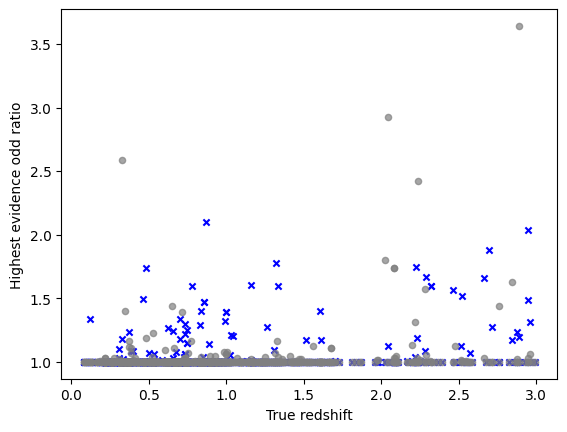

In [26]:
f,a=plt.subplots(1,1)
df_test_more.plot.scatter('True redshift', 'Highest evidence odd ratio', c='blue', marker='x', ax=a)
df_ref_more.plot.scatter('True redshift', 'Highest evidence odd ratio', c='grey', alpha=0.7, ax=a)

In [27]:
def zp_zs_plot(photo_z_df, x_series, y_series, outlier_lim_pct=15, hue=None):
    f,a=plt.subplots(1,1)
    if hue is None:
        df_to_plot = photo_z_df[[photo_z_df.columns[0], x_series, y_series]].copy()
        hue='outlier'
    else:
        df_to_plot = photo_z_df[[photo_z_df.columns[0], x_series, y_series, hue]].copy()
    df_to_plot['bias'] = df_to_plot[y_series]-df_to_plot[x_series]
    df_to_plot['scatter'] = np.abs(df_to_plot['bias']/(1.+df_to_plot[x_series]))
    df_to_plot['outlier'] = (df_to_plot['scatter'] > outlier_lim_pct/100)
    outl_rate = 100.0*len(df_to_plot[df_to_plot['outlier']])/len(df_to_plot)
    
    med = np.median(df_to_plot[x_series])
    resids = np.abs(df_to_plot[y_series] - med)
    
    NMAD = 1.4826 * np.median(df_to_plot['scatter'])

    sns.scatterplot(data=df_to_plot, x=x_series, y=y_series, hue=hue, marker='.', ax=a)
    a.plot(df_to_plot[x_series].values, df_to_plot[x_series].values, c='k', ls=':', lw=0.5)
    a.plot(df_to_plot[x_series].values, outlier_lim_pct/100+(1.+outlier_lim_pct/100)*df_to_plot[x_series].values, c='k', lw=0.5)
    a.plot(df_to_plot[x_series].values, -outlier_lim_pct/100+(1.-outlier_lim_pct/100)*df_to_plot[x_series].values, c='k', lw=0.5)
    a.set_title("$z_{phot}$ vs. $z_{spec}$ : "+f"{outl_rate:.3f}% outliers @{outlier_lim_pct}% ; NMAD={NMAD:.4f}")
    
def which_is_best(photo_z_df):
    poss_src = np.array(['Photometric redshift', 'Highest evidence z_phot (mode)', 'Highest evidence z_phot (mean)'])
    bias_mode = np.abs(photo_z_df['Bias'].values)
    bias_ev_mode = np.abs(photo_z_df['Highest evidence z_phot (mode)'].values - photo_z_df['True redshift'].values)
    bias_ev_mean = np.abs(photo_z_df['Highest evidence z_phot (mean)'].values - photo_z_df['True redshift'].values)
    
    best_pestim = []
    for m, ev_mo, ev_me in zip(bias_mode, bias_ev_mode, bias_ev_mean):
        order = np.argsort([m, ev_mo, ev_me])
        sorted_es = poss_src[order]
        best_pestim.append(sorted_es[0])
        '''
        if ev_me<ev_mo and ev_me<m :
            best_pestim.append('Highest evidence z_phot (mean)')
        elif ev_mo<m and ev_mo<ev_me :
            best_pestim.append('Highest evidence z_phot (mode)')
        else :
            assert (m<=ev_mo and m<=ev_me), "Error in logic."
            best_pestim.append('Photometric redshift')
        '''
                
    best_zp = np.array([ photo_z_df.loc[photo_z_df.index[n], esti] for n,esti in enumerate(best_pestim) ])
    
    photo_z_df['Best estimator']=np.array(best_pestim)
    photo_z_df['Best point estimate']=best_zp
    zp_zs_plot(photo_z_df, 'True redshift', 'Best point estimate', hue='Best estimator')
    

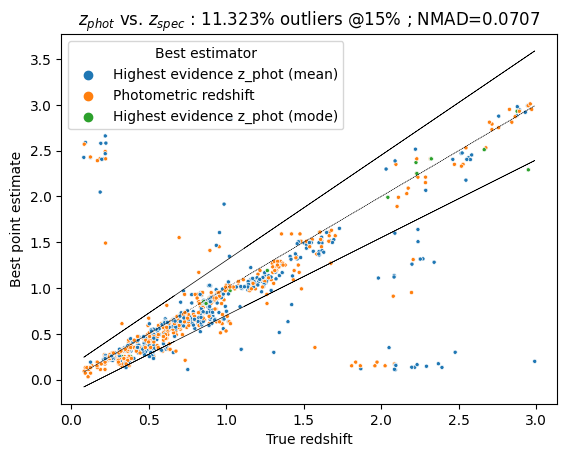

In [28]:
which_is_best(df_test_more)

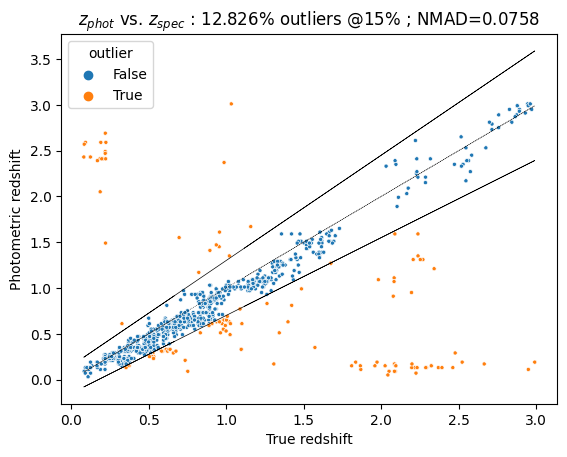

In [29]:
zp_zs_plot(df_test_more, 'True redshift', 'Photometric redshift')

In [30]:
bad_test_df = pd.DataFrame(posteriors_dict_test[bad_case]['5 best models at z_spec'])
bad_ref_df = pd.DataFrame(posteriors_dict_ref[bad_case]['5 best models at z_spec'])
bad_test_df

Template SED Dust law E(B-V)  zp (mode) average(z)  \
0  AVG_Scd_Calzetti_EBV0.103_noDust   Prevot    0.2  1.3299999  1.3319814   
1  AVG_Sbc_Calzetti_EBV0.186_noDust   Prevot    0.2       1.03   1.038238   
2  AVG_Irr_Calzetti_EBV0.103_noDust   Prevot    0.2  1.3299999  1.3395181   
3    AVG_Scd_Prevot_EBV0.228_noDust   Prevot    0.2  1.3499999  1.3605592   
4    AVG_Sbc_Prevot_EBV0.352_noDust   Prevot    0.2       1.01  1.1047748   

        sigma(z)  median(z)      Odd ratio          Bias M(cosmos_u_cfht)  \
0   0.0002708687       1.37   0.0015408525    0.30989993        24.336983   
1   0.0005152258  1.0699999   6.888064e-16   0.009899974        24.197807   
2  0.00020808146       1.37  7.4912265e-08    0.30989993        24.258286   
3   0.0003560032       1.39     0.27477875     0.3298999        24.364067   
4     0.01287931  1.0899999   9.114358e-19  -0.010100007        24.179497   

  M(cosmos_u_new) M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0       24.418434    23.94661   23.568443      23.055    22.51728    22.31437  
1       24.264923   23.862701   23.586403   23.186684   22.575829   22.254509  
2       24.334953   23.889687   23.521286    23.02642   22.559853    22.43467  
3        24.44786   23.980095    23.56565   23.006584   22.511597    22.36412  
4       24.249878   23.853012   23.524086    23.08628   22.590714   22.419228

Text(0, 0.5, '$p(z \\cap model)$')

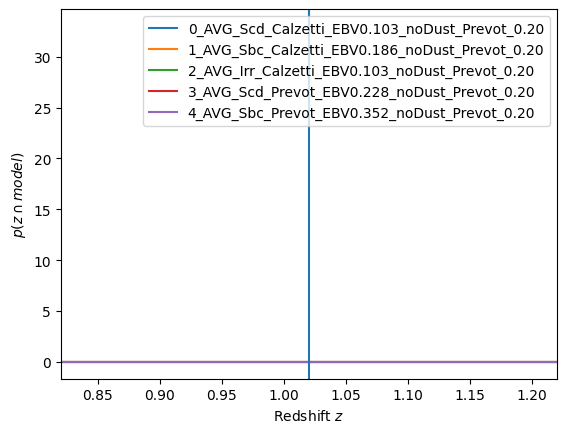

In [31]:
temp_names = np.array([test_inputs['Templates'][t]['name'] for t in test_inputs['Templates']])
posterior = posteriors_dict_test[bad_case]['Full posterior']
for item in bad_test_df.index :
    mod_num=np.argwhere(temp_names == bad_test_df.loc[item, 'Template SED'])[0][0]
    for idust, d in enumerate(dust_arr_test):
        if d.name==bad_test_df.loc[item, 'Dust law'] and d.EBV==bad_test_df.loc[item, 'E(B-V)'] : dust_num = idust
    z_num = np.argwhere(np.abs(z_grid_test-bad_test_df.loc[item, 'zp (mode)'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    #print(temp_names[mod_num])
    #print(dust_arr_test[dust_num])
    #print(z_grid_test[z_num])
    plt.plot(z_grid_test, posterior[mod_num, dust_num, :],\
             label=f"{item}_{bad_test_df.loc[item, 'Template SED']}_{bad_test_df.loc[item, 'Dust law']}_{bad_test_df.loc[item, 'E(B-V)']:.2f}")
plt.axvline(df_test_more.loc[bad_case, "True redshift"])
plt.xlim(df_test_more.loc[bad_case, "True redshift"]-0.2, df_test_more.loc[bad_case, "True redshift"]+0.2)
#plt.ylim(1.e-6, 1.e3)
plt.legend()
plt.xlabel("Redshift $z$")
plt.ylabel("$p(z \cap model)$")
#plt.yscale('log')

In [32]:
good_test_df = pd.DataFrame(posteriors_dict_test[good_case]['5 best models at z_spec'])
good_ref_df = pd.DataFrame(posteriors_dict_ref[good_case]['5 best models at z_spec'])
good_test_df

Template SED  Dust law E(B-V)  zp (mode) average(z)  \
0    AVG_Irr_Prevot_EBV0.103_noDust    Prevot    0.1  1.5699999  1.5583074   
1    AVG_Sbc_Prevot_EBV0.352_noDust    Prevot    0.1  1.5699999  1.5610269   
2  AVG_Irr_Calzetti_EBV0.103_noDust    Prevot    0.1  1.5899999  1.6012542   
3    AVG_Irr_Prevot_EBV0.103_noDust  Calzetti    0.2       1.63  1.6305398   
4    AVG_Scd_Prevot_EBV0.269_noDust  Calzetti    0.1       1.65  1.6548702   

        sigma(z)  median(z)      Odd ratio          Bias M(cosmos_u_cfht)  \
0   0.0005805134  1.5899999     0.47515213    -0.0940001        23.230377   
1  0.00037186276  1.5899999            1.0    -0.0940001        23.187675   
2  0.00025046617       1.63    0.002986552   -0.07400012        23.223114   
3  0.00065359677       1.65  2.3676052e-05   -0.03400004         23.20832   
4  0.00026260078  1.6899999  1.9844526e-07  -0.014000058          23.2184   

  M(cosmos_u_new) M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0       23.275932     22.9561   22.747208   22.646133    22.58274   22.475456  
1       23.242424   22.955795   22.818428   22.722038   22.626762   22.516403  
2       23.288933   22.967964    22.79638    22.64721   22.568733   22.419243  
3       23.223495   23.018265    22.83094     22.7071   22.580261    22.40818  
4       23.242744    23.00943   22.857895   22.684494   22.552696    22.36303

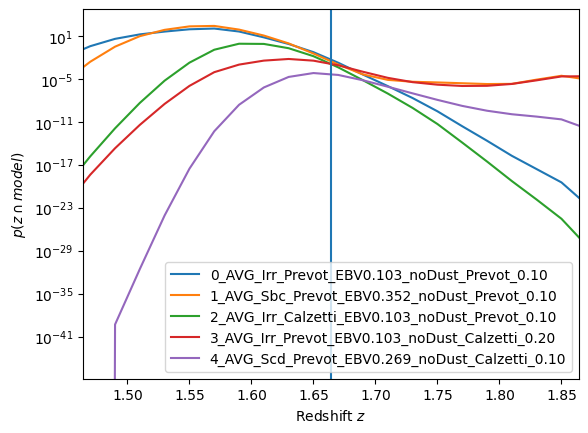

In [33]:
temp_names = np.array([test_inputs['Templates'][t]['name'] for t in test_inputs['Templates']])
posterior = posteriors_dict_test[good_case]['Full posterior']
for item in good_test_df.index :
    mod_num=np.argwhere(temp_names == good_test_df.loc[item, 'Template SED'])[0][0]
    for idust, d in enumerate(dust_arr_test):
        if d.name==good_test_df.loc[item, 'Dust law'] and d.EBV==good_test_df.loc[item, 'E(B-V)'] : dust_num = idust
    z_num = np.argwhere(np.abs(z_grid_test-good_test_df.loc[item, 'zp (mode)'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    plt.plot(z_grid_test, posterior[mod_num, dust_num, :],\
             label=f"{item}_{good_test_df.loc[item, 'Template SED']}_{good_test_df.loc[item, 'Dust law']}_{good_test_df.loc[item, 'E(B-V)']:.2f}")
plt.axvline(df_test_more.loc[good_case, "True redshift"])
plt.xlim(df_test_more.loc[good_case, "True redshift"]-0.2, df_test_more.loc[good_case, "True redshift"]+0.2)
#plt.ylim(1.e-9, 1.e3)
plt.legend()
plt.xlabel("Redshift $z$")
plt.ylabel("$p(z \cap model)$")
plt.yscale('log')

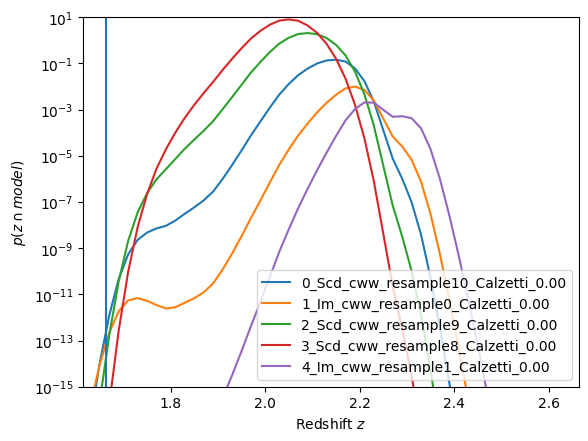

In [34]:
temp_names = np.array([ref_inputs['Templates'][t]['name'] for t in ref_inputs['Templates']])
posterior = posteriors_dict_ref[good_case]['Full posterior']
for item in good_ref_df.index :
    mod_num=np.argwhere(temp_names == good_ref_df.loc[item, 'Template SED'])[0][0]
    for idust, d in enumerate(dust_arr_ref):
        if d.name==good_ref_df.loc[item, 'Dust law'] and d.EBV==good_ref_df.loc[item, 'E(B-V)'] : dust_num = idust
    z_num = np.argwhere(np.abs(z_grid_ref-good_ref_df.loc[item, 'zp (mode)'])<ref_inputs['Z_GRID']['z_step']/10)[0][0]
    plt.plot(z_grid_ref, posterior[mod_num, dust_num, :],\
             label=f"{item}_{good_ref_df.loc[item, 'Template SED']}_{good_ref_df.loc[item, 'Dust law']}_{good_ref_df.loc[item, 'E(B-V)']:.2f}")
plt.axvline(df_ref_more.loc[good_case, "True redshift"])
plt.xlim(df_ref_more.loc[good_case, "True redshift"]-0.05, df_ref_more.loc[good_case, "True redshift"]+1.)
plt.ylim(1.e-15, 1.e1)
plt.legend()
plt.xlabel("Redshift $z$")
plt.ylabel("$p(z \cap model)$")
plt.yscale('log')

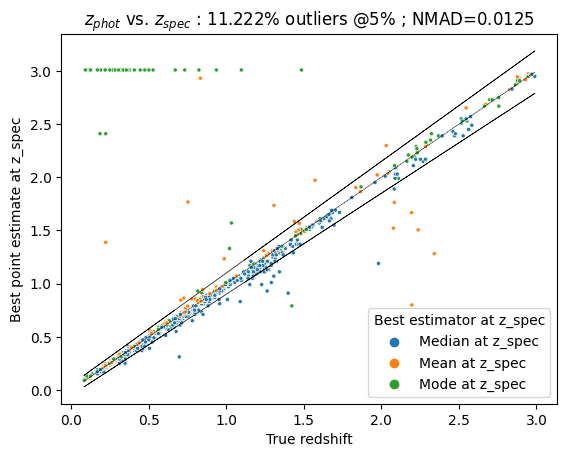

In [35]:
modes_zs = []
means_zs = []
meds_zs = []
best_estim_at_zs = []
best_zp_at_zs = []
temp_names = np.array([test_inputs['Templates'][t]['name'] for t in test_inputs['Templates']])
for loc, _case in enumerate(df_test_more.index):
    posterior = posteriors_dict_test[_case]['Full posterior']
    good_test_df = pd.DataFrame(posteriors_dict_test[_case]['5 best models at z_spec'])
    
    mod_num=np.argwhere(temp_names == good_test_df.loc[0, 'Template SED'])[0][0]
    for idust, d in enumerate(dust_arr_test):
        if d.name==good_test_df.loc[0, 'Dust law'] and d.EBV==good_test_df.loc[0, 'E(B-V)'] : dust_num = idust
    z_num = np.argwhere(np.abs(z_grid_test-good_test_df.loc[0, 'zp (mode)'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    mode_at_zs = good_test_df.loc[0, 'zp (mode)']
    mean_at_zs = good_test_df.loc[0, 'average(z)']
    med_at_zs = good_test_df.loc[0, 'median(z)']
    tru_z = df_test_more.loc[_case, "True redshift"]
    
    poss_zp = np.array([mode_at_zs, mean_at_zs, med_at_zs])
    
    bias_mode = np.abs(mode_at_zs-tru_z)
    bias_mean = np.abs(mean_at_zs-tru_z)
    try :
        bias_med = np.abs(med_at_zs-tru_z)
    except TypeError:
        bias_med = 99
    
    poss_src = np.array(['Mode at z_spec', 'Mean at z_spec', 'Median at z_spec'])
    
    best_pestim = []

    order = np.argsort([bias_mode, bias_mean, bias_med])
    sorted_es = poss_src[order]
    sorted_zp = poss_zp[order]
    best_estim_at_zs.append(sorted_es[0])
    best_zp_at_zs.append(sorted_zp[0])
    
df_test_more['Best estimator at z_spec']=np.array(best_estim_at_zs)
df_test_more['Best point estimate at z_spec']=np.array(best_zp_at_zs)
zp_zs_plot(df_test_more, 'True redshift', 'Best point estimate at z_spec', outlier_lim_pct=5, hue='Best estimator at z_spec')

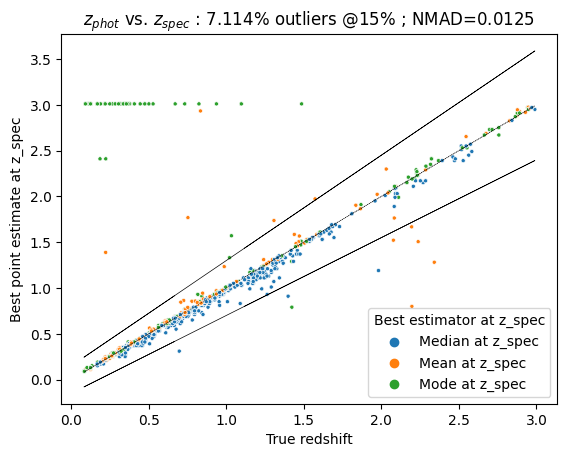

In [36]:
zp_zs_plot(df_test_more, 'True redshift', 'Best point estimate at z_spec', outlier_lim_pct=15, hue='Best estimator at z_spec')

## Z-spec models study

<AxesSubplot:xlabel='Odd ratio of best model at z_spec', ylabel='Count'>

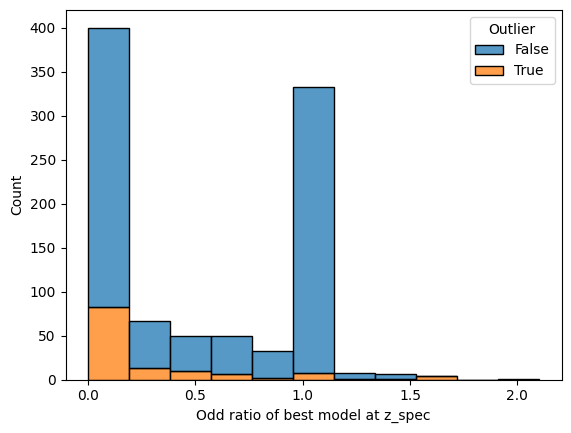

In [37]:
sns.histplot(data=df_test_more, x='Odd ratio of best model at z_spec', hue='Outlier', stat='count', multiple='stack')

In [38]:
len(np.unique(df_test_more['Best SED at z_spec'].values))

44

In [39]:
len(np.unique(df_test_more['Template SED'].values))

48

Not many templates are rejected during the run. Too bad !

In [40]:
np.nanmean(df_test_more['Odd ratio of best model at z_spec'].values)

0.5006484878557844

In [41]:
sub_df = df_test_more[np.isfinite(df_test_more['Odd ratio of best model at z_spec'].values)]
len(sub_df)

950

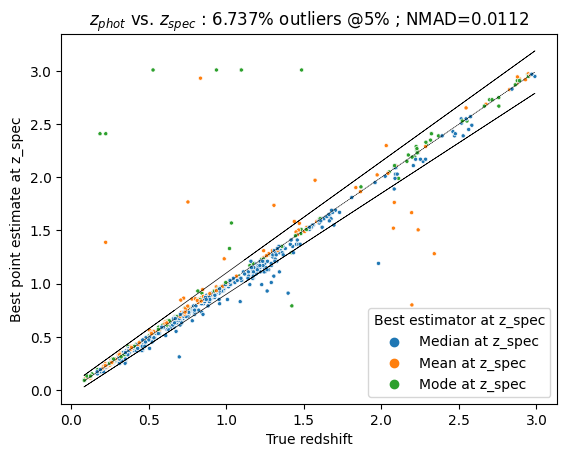

In [42]:
zp_zs_plot(sub_df, 'True redshift', 'Best point estimate at z_spec', outlier_lim_pct=5, hue='Best estimator at z_spec')

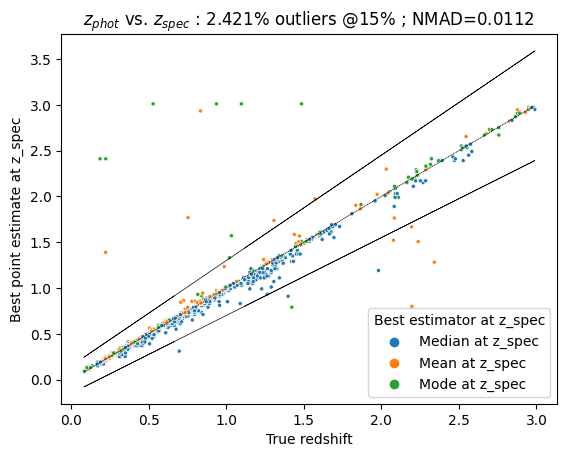

In [43]:
zp_zs_plot(sub_df, 'True redshift', 'Best point estimate at z_spec', hue='Best estimator at z_spec')

In [44]:
np.mean(sub_df['Odd ratio of best model at z_spec'].values)

0.5006484878557844

In [45]:
np.median(sub_df['Odd ratio of best model at z_spec'].values)

0.4163021445274353

<AxesSubplot:xlabel='Odd ratio of best model at z_spec', ylabel='Count'>

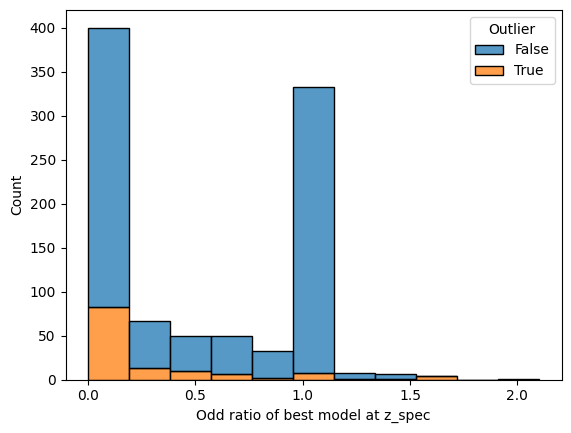

In [46]:
sns.histplot(data=sub_df, x='Odd ratio of best model at z_spec', hue='Outlier', stat='count', multiple='stack')

In [47]:
sub_df = df_test_more[[not b for b in np.isfinite(df_test_more['Odd ratio of best model at z_spec'].values)]]
len(sub_df)

48

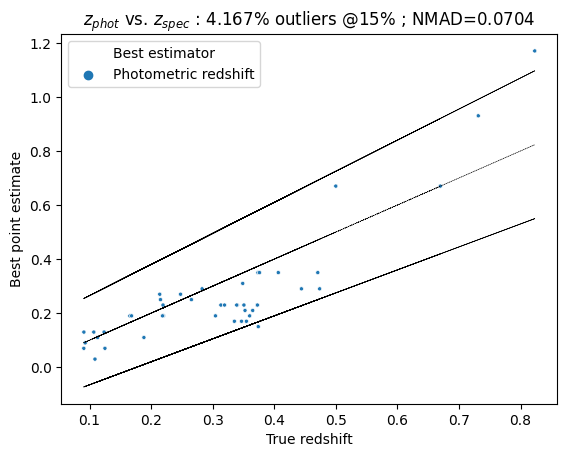

In [48]:
zp_zs_plot(sub_df, 'True redshift', 'Best point estimate', hue='Best estimator')

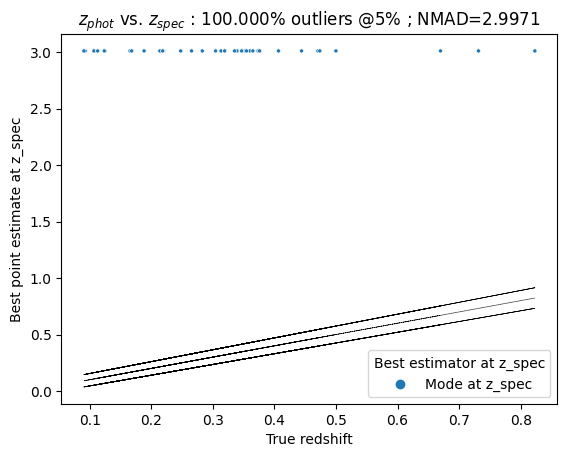

In [49]:
zp_zs_plot(sub_df, 'True redshift', 'Best point estimate at z_spec', outlier_lim_pct=5, hue='Best estimator at z_spec')

In [50]:
sub_df[[c for c in sub_df.columns if 'evidence' in c]]

Highest evidence SED Highest evidence dust law  \
34   AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
38   AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
48   AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
113  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
115  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
154  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
157  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
174  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
188  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
195  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
204  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
253  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
276  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
281  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
296  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
299  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
330  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
331  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
338  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
370  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
375  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
376  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
413  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
415  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
423  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
442  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
461  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
511  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
541  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
583  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
667  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
713  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
717  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
736  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
738  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
766  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
771  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
801  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
829  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
831  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
868  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
878  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
892  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
927  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
932  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
940  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
974  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   
976  AVG_Scd_Prevot_EBV0.269_noDust                    Prevot   

     Highest evidence E(B-V)  Highest evidence odd ratio  \
34                       0.4                         NaN   
38                       0.4                         NaN   
48                       0.4                         NaN   
113                      0.4                         NaN   
115                      0.4                         NaN   
154                      0.4                         NaN   
157                      0.4                         NaN   
174                      0.4                         NaN   
188                      0.4                         NaN   
195                      0.4                         NaN   
204                      0.4                         NaN   
253                      0.4                         NaN   
276                      0.4                     

In [51]:
id_zarbi=34
posterior = posteriors_dict_test[id_zarbi]['Full posterior']
zarbi_df_zs = pd.DataFrame(posteriors_dict_test[id_zarbi]['5 best models at z_spec'])
zarbi_df_ev = pd.DataFrame(posteriors_dict_test[id_zarbi]['5 most likely models'])

In [52]:
zarbi_df_zs

Template SED  Dust law E(B-V) zp (mode) average(z)  \
0  AVG_Scd_Prevot_EBV0.269_noDust    Prevot    0.4      3.01        nan   
1  AVG_Scd_Prevot_EBV0.269_noDust    Prevot    0.2      3.01        nan   
2  AVG_Scd_Prevot_EBV0.269_noDust    Prevot    0.1      3.01        nan   
3  AVG_Scd_Prevot_EBV0.269_noDust    Prevot    0.0      3.01        nan   
4  AVG_Scd_Prevot_EBV0.269_noDust  Calzetti    0.4      3.01        nan   

  sigma(z) median(z) Odd ratio    Bias M(cosmos_u_cfht) M(cosmos_u_new)  \
0      nan      None       nan  2.9192        20.758018       20.886055   
1      nan      None       nan  2.9192        20.797745       20.890305   
2      nan      None       nan  2.9192        20.840324       20.915672   
3      nan      None       nan  2.9192        20.888405       20.946846   
4      nan      None       nan  2.9192         20.77108       20.924759   

  M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0   19.776306   19.377441   19.134758    18.87764   18.724869  
1    20.03305   19.817268   19.655678   19.459702   19.352547  
2   20.182968   20.060577   19.939674   19.774406   19.690025  
3   20.337502   20.309792   20.229683   20.095192   20.033562  
4   19.785225   19.311943   18.883057   18.536873   18.353172

In [53]:
zarbi_df_ev

Template SED  Dust law E(B-V) zp (mode) average(z)  \
0  AVG_Scd_Prevot_EBV0.269_noDust    Prevot    0.4      3.01        nan   
1  AVG_Scd_Prevot_EBV0.269_noDust    Prevot    0.2      3.01        nan   
2  AVG_Scd_Prevot_EBV0.269_noDust    Prevot    0.1      3.01        nan   
3  AVG_Scd_Prevot_EBV0.269_noDust    Prevot    0.0      3.01        nan   
4  AVG_Scd_Prevot_EBV0.269_noDust  Calzetti    0.4      3.01        nan   

  sigma(z) median(z) Odd ratio    Bias M(cosmos_u_cfht) M(cosmos_u_new)  \
0      nan      None       nan  2.9192        25.205116       26.380684   
1      nan      None       nan  2.9192         22.65638       23.552536   
2      nan      None       nan  2.9192        21.494133       22.284416   
3      nan      None       nan  2.9192         20.82595        21.52552   
4      nan      None       nan  2.9192        22.390137       23.333855   

  M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0   21.950172    19.72065     18.5766   17.964088   17.650963  
1   20.287743   18.932594    18.28569   17.959152    17.84935  
2   19.571724   18.668648   18.284126   18.102684   18.095398  
3   19.339668   18.902153    18.79036   18.755455    18.85128  
4   19.934914   18.834114   18.285362   17.978691   17.891449

In [54]:
sub_df = df_test_more[np.isfinite(df_test_more['Odd ratio of best model at z_spec'].values)]

In [55]:
sub_df[[c for c in sub_df.columns if 'evidence' in c]]

Highest evidence SED Highest evidence dust law  \
0     AVG_Irr_Calzetti_EBV0.021_noDust                    Prevot   
1       AVG_Sbc_Prevot_EBV0.145_noDust                    Prevot   
2       AVG_Irr_Prevot_EBV0.145_noDust                    Prevot   
3     AVG_Scd_Calzetti_EBV0.228_noDust                    Prevot   
4    AVG_E-S0_Calzetti_EBV0.228_noDust                    Prevot   
..                                 ...                       ...   
995   AVG_Irr_Calzetti_EBV0.062_noDust                    Prevot   
996    AVG_E-S0_Prevot_EBV0.062_noDust                  Calzetti   
997   AVG_Scd_Calzetti_EBV0.062_noDust                    Prevot   
998     AVG_Scd_Prevot_EBV0.186_noDust                    Prevot   
999     AVG_Scd_Prevot_EBV0.186_noDust                    Prevot   

     Highest evidence E(B-V)  Highest evidence odd ratio  \
0                        0.1                    1.000000   
1                        0.1                    1.000000   
2                        0.2                    1.000000   
3                        0.2                    1.000000   
4                        0.2                    1.000000   
..                       ...                         ...   
995                      0.1                    1.659939   
996                      0.1                    1.217816   
997                      0.2                    1.000000   
998                      0.2                    2.101376   
999                      0.1                    1.000000   

     Highest evidence z_phot (mode)  Highest evidence z_phot (mean)  \
0                              0.53                        0.537294   
1                              0.29                        0.285286   
2                              0.23                        0.227985   
3                              0.61                        0.606673   
4                              1.35                        1.346262   
..                              ...                             ...   
995                            2.51                        2.480472   
996                            0.73                        0.720937   
997                            0.65                        0.651641   
998                            0.83                        0.822054   
999                            1.01                        1.013005   

     Highest evidence sigma(z)  
0                     0.000157  
1                     0.000072  
2                     0.000040  
3                     0.000474  
4                     0.000578  
..                         ...  
995                   0.022563  
996                   0.000099  
997                   0.000199  
998                   0.000561  
999                   0.000172  

[950 rows x 7 columns]

<AxesSubplot:xlabel='Highest evidence odd ratio', ylabel='Count'>

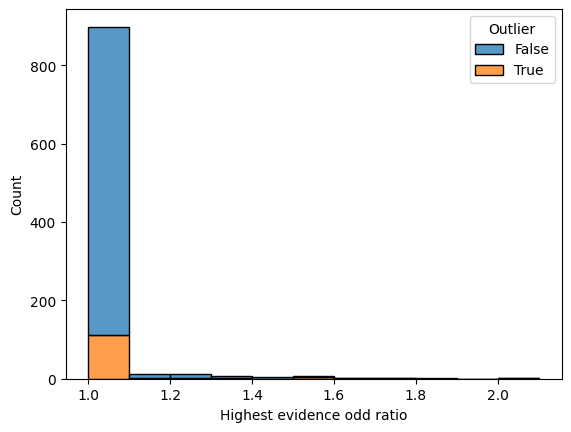

In [56]:
sns.histplot(data=sub_df, x='Highest evidence odd ratio', hue='Outlier', stat='count', multiple='stack')

In [57]:
id_test_pointEst=15
posterior = posteriors_dict_test[id_test_pointEst]['Full posterior']
pointEst_df_ev = pd.DataFrame(posteriors_dict_test[id_test_pointEst]['5 most likely models'])
pointEst_df_ev

Template SED  Dust law E(B-V) zp (mode) average(z)  \
0    AVG_Irr_Prevot_EBV0.145_noDust    Prevot    0.1      2.57  2.5153055   
1  AVG_Irr_Calzetti_EBV0.103_noDust    Prevot    0.1      2.61   2.595491   
2    AVG_Scd_Prevot_EBV0.228_noDust    Prevot    0.1      2.59   2.525764   
3    AVG_Irr_Prevot_EBV0.103_noDust    Prevot    0.1      2.61  2.5909615   
4    AVG_Scd_Prevot_EBV0.269_noDust  Calzetti    0.1      2.59  2.5594916   

       sigma(z)  median(z)   Odd ratio        Bias M(cosmos_u_cfht)  \
0   0.009957016       2.55   1.0347666  0.34969997        25.710236   
1  0.0067753764  2.6299999         1.0  0.38969994         25.70591   
2   0.020965055       2.57  0.83173263  0.36969995         25.71762   
3   0.006723609  2.6299999    0.780088  0.38969994        25.720978   
4  0.0070432816       2.59   0.6465418  0.36969995        25.723969   

  M(cosmos_u_new) M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0       25.892914   24.875511   24.455345   24.260735   24.204887    24.11325  
1        25.92826     24.8527    24.44558    24.26567   24.216179   24.132057  
2       25.914146   24.878105    24.46251   24.253555   24.203789   24.108559  
3       25.951881   24.865074    24.46714    24.25396   24.190933   24.135262  
4       25.973434   24.775536   24.460838   24.259392    24.26345   24.148102

In [58]:
def weighted_point_est(true_z, a,b,c):
    a1 = a*pointEst_df_ev.loc[0, 'Odd ratio']
    b1 = b*pointEst_df_ev.loc[1, 'Odd ratio']
    c1 = c*pointEst_df_ev.loc[2, 'Odd ratio']
    z_pointEst = (a1*pointEst_df_ev.loc[0, 'average(z)'] + b1*pointEst_df_ev.loc[1, 'average(z)'] + c1*pointEst_df_ev.loc[2, 'average(z)'])/(a1+b1+c1)
    bias = np.abs(true_z-z_pointEst)
    return bias

In [59]:
weighted_point_est(sub_df.loc[id_test_pointEst, 'True redshift'], 1,1,1)

0.32601333

In [60]:
sub_df.loc[id_test_pointEst, 'Bias']

0.38969989509582525

In [61]:
sub_sub_df = sub_df[sub_df['Highest evidence odd ratio'] > 1.]
sub_sub_df

Id  Photometric redshift  True redshift  \
15    6568.0                  2.61         2.2203   
20    5992.0                  0.29         0.6585   
28   11933.0                  0.91         0.8550   
32   13852.0                  0.33         0.3713   
42   16793.0                  0.33         0.3980   
..       ...                   ...            ...   
958   4905.0                  0.07         2.2239   
994   3065.0                  2.93         2.8903   
995   5756.0                  0.17         2.6639   
996  16455.0                  0.73         0.7336   
998   3751.0                  0.73         0.8700   

                         Template SED Extinction law  E(B-V)        Chi2  \
15   AVG_Irr_Calzetti_EBV0.103_noDust         Prevot     0.1   29.559309   
20     AVG_Sbc_Prevot_EBV0.062_noDust       Calzetti     0.2   37.912598   
28     AVG_Irr_Prevot_EBV0.145_noDust         Prevot     0.2   21.618641   
32     AVG_Sbc_Prevot_EBV0.145_noDust       Calzetti     0.0  156.908279   
42     AVG_Scd_Prevot_EBV0.228_noDust       Calzetti     0.0   27.507629   
..                                ...            ...     ...         ...   
958    AVG_Irr_Prevot_EBV0.145_noDust       Calzetti     0.0   24.143747   
994  AVG_Irr_Calzetti_EBV0.062_noDust         Prevot     0.1   28.829750   
995    AVG_Irr_Prevot_EBV0.145_noDust         Prevot     0.1   26.121231   
996   AVG_E-S0_Prevot_EBV0.103_noDust       Calzetti     0.1    6.015019   
998    AVG_Sbc_Prevot_EBV0.269_noDust         Prevot     0.1   38.833015   

                 Highest evidence SED Highest evidence dust law  \
15     AVG_Irr_Prevot_EBV0.145_noDust                    Prevot   
20     AVG_Sbc_Prevot_EBV0.062_noDust                  Calzetti   
28     AVG_Scd_Prevot_EBV0.228_noDust                    Prevot   
32     AVG_Sbc_Prevot_EBV0.145_noDust                    Prevot   
42     AVG_Irr_Prevot_EBV0.103_noDust                    Prevot   
..                                ...                       ...   
958    AVG_Irr_Prevot_EBV0.145_noDust                  Calzetti   
994  AVG_Irr_Calzetti_EBV0.103_noDust                    Prevot   
995  AVG_Irr_Calzetti_EBV0.062_noDust                    Prevot   
996   AVG_E-S0_Prevot_EBV0.062_noDust                  Calzetti   
998    AVG_Scd_Prevot_EBV0.186_noDust                    Prevot   

     Highest evidence E(B-V)  ...  MagAB(hsc_yHSC)  err_MagAB(hsc_yHSC)  \
15                       0.1  ...        24.110420             0.039643   
20                       0.2  ...        20.380989             0.004934   
28                       0.2  ...        22.876518             0.018696   
32                       0.0  ...        20.539902             0.004475   
42                       0.1  ...        24.733406             0.083563   
..                       ...  ...              ...                  ...   
958                      0.1  ...        23.779907             0.030853   
994                      0.1  ...        24.181839             0.042466   
995                      0.1  ...        23.761284             0.029802   
996                      0.1  ...        19.879967             0.003540   
998                      0.2  ...        21.319901             0.006395   

       Bias  Outlier       U-B       R-I                  Best estimator  \
15   0.3897    False  1.248039  0.118515  Highest evidence z_phot (mean)   
20  -0.3685     True       NaN  0.675446  Highest evidence z_phot (mean)   
28   0.0550    False  0.297150  0.714455  Highest evidence z_phot (mode)   
32  -0.0413    False  0.663513  0.258209  Highest evidence z_phot (mean)   
42  -0.0680    False  0.332962  0.061661  Highest evidence z_phot (mode)   
..      ...      ...       ...       ...                             ...   
958 -2.1539     True  0.612869  0.020073  Highest evidence z_phot (mode)   
994  0.0397    False  1.238106  0.170616            Photometric redshift   
995 -2.4939     True  0.890648  0.072914  Highest evidence z_phot (mod

In [62]:
from scipy.optimize import curve_fit

y_data = np.abs(sub_df['Best point estimate at z_spec'].values - sub_df['True redshift'].values)
x_data = np.array(sub_df.index)

def get_odd_ratios(xx, rank):
    odd_rat = []
    for x in xx :
        pointEst_df_ev = pd.DataFrame(posteriors_dict_test[x]['5 most likely models'])
        odd_rat.append(pointEst_df_ev.loc[rank, 'Odd ratio'])
    return np.array(odd_rat)

def get_avg_z(xx, rank):
    avg_z = []
    for x in xx :
        pointEst_df_ev = pd.DataFrame(posteriors_dict_test[x]['5 most likely models'])
        avg_z.append(pointEst_df_ev.loc[rank, 'average(z)'])
    return np.array(avg_z)

a_vals, b_vals, c_vals = get_odd_ratios(x_data, 0), get_odd_ratios(x_data, 1), get_odd_ratios(x_data, 2)
z1_vals, z2_vals, z3_vals = get_avg_z(x_data, 0), get_avg_z(x_data, 1), get_avg_z(x_data, 2)

In [63]:
def weighted_point_est(idx:int, a,b,c):
    true_z = sub_df.loc[idx, 'True redshift']
    pointEst_df_ev = pd.DataFrame(posteriors_dict_test[int(idx[0])]['5 most likely models'])
    a1 = a*pointEst_df_ev.loc[0, 'Odd ratio']
    b1 = b*pointEst_df_ev.loc[1, 'Odd ratio']
    c1 = c*pointEst_df_ev.loc[2, 'Odd ratio']
    z_pointEst = (a1*pointEst_df_ev.loc[0, 'average(z)'] + b1*pointEst_df_ev.loc[1, 'average(z)'] + c1*pointEst_df_ev.loc[2, 'average(z)'])/(a1+b1+c1)
    bias = np.abs(true_z-z_pointEst)
    return bias

res = curve_fit(weighted_point_est, x_data, y_data, p0=(1.,1.,1.))
res

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([1., 1., 1.]),
 array([[inf, inf, inf],
        [inf, inf, inf],
        [inf, inf, inf]]))

Optimization by this means fails. May be a minimize?

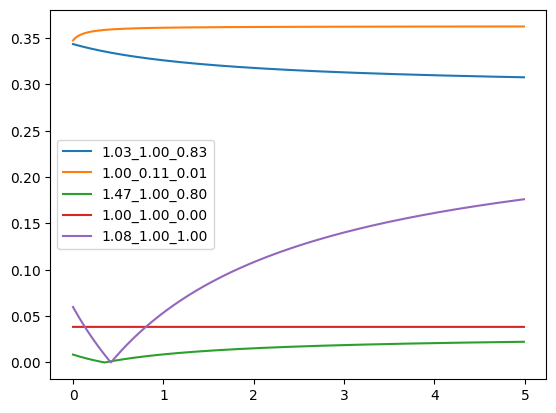

In [64]:
from scipy.optimize import minimize
x_data = np.array(sub_sub_df.index)
alist=np.arange(0., 5., 0.01)
for idx in x_data[:5]:
    true_z = sub_df.loc[idx, 'True redshift']
    pointEst_df_ev = pd.DataFrame(posteriors_dict_test[idx]['5 most likely models'])
    
    def weighted_point_est(abc):
        a,b,c = abc
        a1 = a*pointEst_df_ev.loc[0, 'Odd ratio']
        b1 = b*pointEst_df_ev.loc[1, 'Odd ratio']
        c1 = c*pointEst_df_ev.loc[2, 'Odd ratio']
        z_pointEst = (a1*pointEst_df_ev.loc[0, 'average(z)'] + b1*pointEst_df_ev.loc[1, 'average(z)'] + c1*pointEst_df_ev.loc[2, 'average(z)'])/(a1+b1+c1)
        bias = np.abs(true_z-z_pointEst)
        return bias
    
    #res = minimize(weighted_point_est, (1.,1.,1.))
    #print(res)
    
    biases = [weighted_point_est((a,1.,1.)) for a in alist]
    
    plt.plot(alist, biases, label=f"{pointEst_df_ev.loc[0, 'Odd ratio']:.2f}_{pointEst_df_ev.loc[1, 'Odd ratio']:.2f}_{pointEst_df_ev.loc[2, 'Odd ratio']:.2f}")
plt.legend()

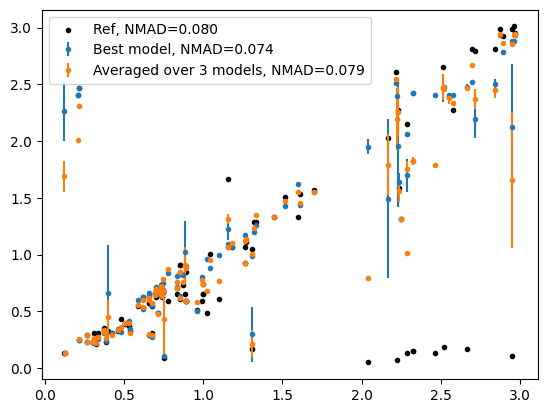

In [65]:
new_pe_z = []
new_pe_sig = []
best_mod_pe = []
best_mod_sig = []
for idx in x_data:
    pointEst_df_ev = pd.DataFrame(posteriors_dict_test[idx]['5 most likely models'])
    a1 = pointEst_df_ev.loc[0, 'Odd ratio']
    b1 = pointEst_df_ev.loc[1, 'Odd ratio']
    c1 = pointEst_df_ev.loc[2, 'Odd ratio']
    z_pointEst = (a1*pointEst_df_ev.loc[0, 'average(z)'] + b1*pointEst_df_ev.loc[1, 'average(z)'] + c1*pointEst_df_ev.loc[2, 'average(z)'])/(a1+b1+c1)
    bias = np.abs(true_z-z_pointEst)
    
    var_pointEst = np.power(a1*pointEst_df_ev.loc[0, 'sigma(z)']/(a1+b1+c1), 2.)\
                    + np.power(b1*pointEst_df_ev.loc[1, 'sigma(z)']/(a1+b1+c1), 2.)\
                    + np.power(c1*pointEst_df_ev.loc[2, 'sigma(z)']/(a1+b1+c1), 2.)
    
    best_mod_pe.append(pointEst_df_ev.loc[0, 'average(z)'])
    best_mod_sig.append(pointEst_df_ev.loc[0, 'sigma(z)'])
    
    new_pe_z.append(z_pointEst)
    new_pe_sig.append(var_pointEst**0.5)

med = np.median(sub_sub_df['True redshift'].values)    

scat_ref = np.abs(sub_sub_df['Photometric redshift'].values-sub_sub_df['True redshift'].values)/(1+sub_sub_df['True redshift'].values)
scat_bm = np.abs(best_mod_pe-sub_sub_df['True redshift'].values)/(1+sub_sub_df['True redshift'].values)
scat_npe = np.abs(new_pe_z-sub_sub_df['True redshift'].values)/(1+sub_sub_df['True redshift'].values)

NMAD_ref = 1.4826 * np.median(scat_ref)
NMAD_bm = 1.4826 * np.median(scat_bm)
NMAD_npe = 1.4826 * np.median(scat_npe)

plt.scatter(sub_sub_df['True redshift'].values, sub_sub_df['Photometric redshift'].values, marker=".", c='k', label=f"Ref, NMAD={NMAD_ref:.3f}")
plt.errorbar(sub_sub_df['True redshift'].values, best_mod_pe, yerr=best_mod_sig, fmt=".", label=f"Best model, NMAD={NMAD_bm:.3f}")
plt.errorbar(sub_sub_df['True redshift'].values, new_pe_z, yerr=new_pe_sig, fmt=".", label=f"Averaged over 3 models, NMAD={NMAD_npe:.3f}")
plt.legend()

## Rank of best model at $z_{spec}$

### Re-compute the evidences

In [66]:
# Include evidence-derived properties
_case = id_test_pointEst
probsarr = posteriors_dict_test[_case]['Full posterior']
evs_nosplit = Analysis.evidence(probsarr, len(extlaws_dict_test), z_grid_test, split_laws=False)
sorted_evs_flat = jnp.argsort(evs_nosplit, axis=None)
sorted_evs = [ jnp.unravel_index(idx, evs_nosplit.shape) for idx in sorted_evs_flat ]
sorted_evs.reverse()
print(sorted_evs[1])

(DeviceArray(18, dtype=int32), DeviceArray(5, dtype=int32))


### Identify the coordinates of z-spec model

In [67]:
good_test_df = pd.DataFrame(posteriors_dict_test[_case]['5 best models at z_spec'])

mod_num=np.argwhere(temp_names == good_test_df.loc[0, 'Template SED'])[0][0]
for idust, d in enumerate(dust_arr_test):
    if d.name==good_test_df.loc[0, 'Dust law'] and d.EBV==good_test_df.loc[0, 'E(B-V)'] : dust_num = idust
z_num = np.argwhere(np.abs(z_grid_test-good_test_df.loc[0, 'zp (mode)'])<test_inputs['Z_GRID']['z_step']/10)[0][0]

print((mod_num, dust_num, z_num))

(47, 5, 106)


### Cros-match to find rank

In [68]:
found=[t==mod_num and d==dust_num for (t,d) in sorted_evs]
np.argwhere(found)[0][0]

10

### Histogram

In [69]:
ranks=[]
for _case in tqdm(sub_df.index):
    probsarr = posteriors_dict_test[_case]['Full posterior']
    evs_nosplit = Analysis.evidence(probsarr, len(extlaws_dict_test), z_grid_test, split_laws=False)
    sorted_evs_flat = jnp.argsort(evs_nosplit, axis=None)
    sorted_evs = [ jnp.unravel_index(idx, evs_nosplit.shape) for idx in sorted_evs_flat ]
    sorted_evs.reverse()
    
    good_test_df = pd.DataFrame(posteriors_dict_test[_case]['5 best models at z_spec'])

    mod_num=np.argwhere(temp_names == good_test_df.loc[0, 'Template SED'])[0][0]
    for idust, d in enumerate(dust_arr_test):
        if d.name==good_test_df.loc[0, 'Dust law'] and d.EBV==good_test_df.loc[0, 'E(B-V)'] : dust_num = idust
    z_num = np.argwhere(np.abs(z_grid_test-good_test_df.loc[0, 'zp (mode)'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    
    found=[t==mod_num and d==dust_num for (t,d) in sorted_evs]
    ranks.append(np.argwhere(found)[0][0])
    
#plt.hist(ranks)

100%|██████████| 950/950 [06:21<00:00,  2.49it/s]


<AxesSubplot:ylabel='Count'>

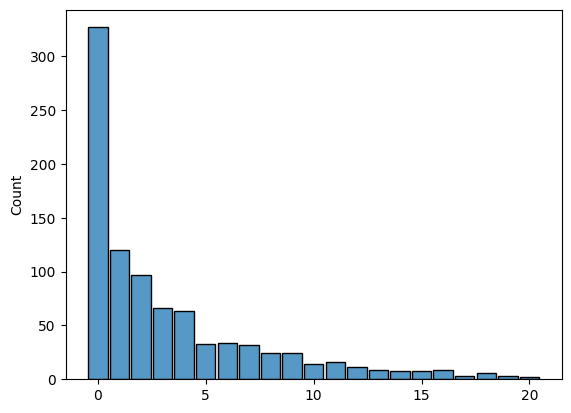

In [70]:
sns.histplot(x=ranks, discrete=True, binrange=(0,20), shrink=0.9)

In [71]:
ranks_zp=[]
for _case in tqdm(sub_df.index):
    probsarr = posteriors_dict_test[_case]['Full posterior']
    evs_nosplit = Analysis.evidence(probsarr, len(extlaws_dict_test), z_grid_test, split_laws=False)
    sorted_evs_flat = jnp.argsort(evs_nosplit, axis=None)
    sorted_evs = [ jnp.unravel_index(idx, evs_nosplit.shape) for idx in sorted_evs_flat ]
    sorted_evs.reverse()

    mod_num=np.argwhere(temp_names == sub_df.loc[_case, 'Template SED'])[0][0]
    for idust, d in enumerate(dust_arr_test):
        if d.name==sub_df.loc[_case, 'Extinction law'] and d.EBV==sub_df.loc[_case, 'E(B-V)'] : dust_num = idust
    z_num = np.argwhere(np.abs(z_grid_test-sub_df.loc[_case, 'Photometric redshift'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    
    found=[t==mod_num and d==dust_num for (t,d) in sorted_evs]
    ranks_zp.append(np.argwhere(found)[0][0])
    
#sns.histplot(x=ranks_zp, discrete=True, binrange=(0,20), shrink=0.9)

100%|██████████| 950/950 [06:18<00:00,  2.51it/s]


### Rank of $min(\chi^2)$ model in terms of $z_{spec}$

In [72]:
ranks_at_zs=[]
for _case in tqdm(sub_df.index):
    if jnp.isfinite(sub_df.loc[_case, 'True redshift']):
        zs=sub_df.loc[_case, 'True redshift']
        probsarr = posteriors_dict_test[_case]['Full posterior']
        if len(extlaws_dict_test)==1 and len(ebv_vals_test)==1:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z_noDust(probsarr, zs, len(baseTemp_arr_test), z_grid_test,\
                                                                  renormalize=True, prenormalize=False)
        elif len(extlaws_dict_test)==1:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z_oneLaw(probsarr, zs, len(baseTemp_arr_test),\
                                                                  ebv_vals_test, z_grid_test, renormalize=True, prenormalize=False)
        elif len(ebv_vals_test)==1:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z_oneEBV(probsarr, zs, len(baseTemp_arr_test), len(extlaws_dict_test),\
                                                                  z_grid_test, renormalize=True, prenormalize=False)
        else:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z(probsarr, zs, len(baseTemp_arr_test), len(extlaws_dict_test),\
                                                           ebv_vals_test, z_grid_test, renormalize=True, prenormalize=False)
        sorted_pzfix_flat = jnp.argsort(p_zfix_nosplit, axis=None)
        sorted_pzfix = [ jnp.unravel_index(idx, p_zfix_nosplit.shape) for idx in sorted_pzfix_flat ]
        sorted_pzfix.reverse()
        
        mod_num=np.argwhere(temp_names == sub_df.loc[_case, 'Template SED'])[0][0]
        for idust, d in enumerate(dust_arr_test):
            if d.name==sub_df.loc[_case, 'Extinction law'] and d.EBV==sub_df.loc[_case, 'E(B-V)'] : dust_num = idust
        z_num = np.argwhere(np.abs(z_grid_test-sub_df.loc[_case, 'Photometric redshift'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    
        found=[t==mod_num and d==dust_num for (t,d) in sorted_pzfix]
        ranks_at_zs.append(np.argwhere(found)[0][0])
    
#sns.histplot(x=ranks_at_zs, discrete=True, binrange=(0,20), shrink=0.9)

100%|██████████| 950/950 [07:45<00:00,  2.04it/s] 


In [73]:
ranks_ev_at_zs=[]
for _case in tqdm(sub_df.index):
    if jnp.isfinite(sub_df.loc[_case, 'True redshift']):
        zs=sub_df.loc[_case, 'True redshift']
        probsarr = posteriors_dict_test[_case]['Full posterior']
        if len(extlaws_dict_test)==1 and len(ebv_vals_test)==1:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z_noDust(probsarr, zs, len(baseTemp_arr_test), z_grid_test,\
                                                                  renormalize=True, prenormalize=False)
        elif len(extlaws_dict_test)==1:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z_oneLaw(probsarr, zs, len(baseTemp_arr_test),\
                                                                  ebv_vals_test, z_grid_test, renormalize=True, prenormalize=False)
        elif len(ebv_vals_test)==1:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z_oneEBV(probsarr, zs, len(baseTemp_arr_test), len(extlaws_dict_test),\
                                                                  z_grid_test, renormalize=True, prenormalize=False)
        else:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z(probsarr, zs, len(baseTemp_arr_test), len(extlaws_dict_test),\
                                                           ebv_vals_test, z_grid_test, renormalize=True, prenormalize=False)
        sorted_pzfix_flat = jnp.argsort(p_zfix_nosplit, axis=None)
        sorted_pzfix = [ jnp.unravel_index(idx, p_zfix_nosplit.shape) for idx in sorted_pzfix_flat ]
        sorted_pzfix.reverse()
        
        mod_num=np.argwhere(temp_names == sub_df.loc[_case, 'Highest evidence SED'])[0][0]
        for idust, d in enumerate(dust_arr_test):
            if d.name==sub_df.loc[_case, 'Highest evidence dust law'] and d.EBV==sub_df.loc[_case, 'Highest evidence E(B-V)'] : dust_num = idust
        z_num = np.argwhere(np.abs(z_grid_test-sub_df.loc[_case, 'Photometric redshift'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    
        found=[t==mod_num and d==dust_num for (t,d) in sorted_pzfix]
        ranks_ev_at_zs.append(np.argwhere(found)[0][0])
    
#sns.histplot(x=ranks_ev_at_zs, discrete=True, binrange=(0,20), shrink=0.9)

100%|██████████| 950/950 [06:29<00:00,  2.44it/s]


In [74]:
sub_df['photo-z model ranking at z_spec']=np.array(ranks_at_zs)

/tmp/ipykernel_20313/2852833274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['photo-z model ranking at z_spec']=np.array(ranks_at_zs)


<AxesSubplot:xlabel='photo-z model ranking at z_spec', ylabel='Count'>

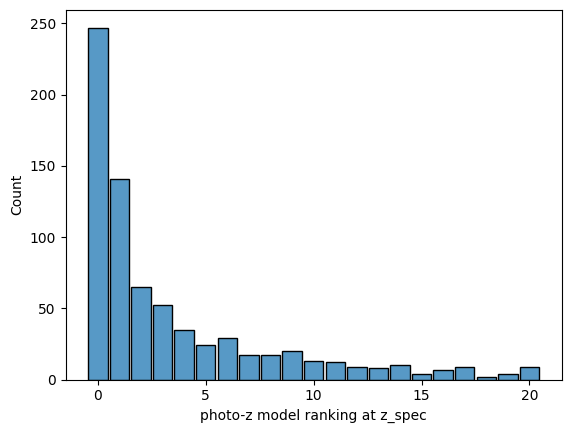

In [75]:
sns.histplot(data=sub_df, x='photo-z model ranking at z_spec', discrete=True, binrange=(0,20), shrink=0.9, multiple='stack')

/tmp/ipykernel_20313/1501437297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Highest evidence model ranking at z_spec']=np.array(ranks_ev_at_zs)


<AxesSubplot:xlabel='Highest evidence model ranking at z_spec', ylabel='Count'>

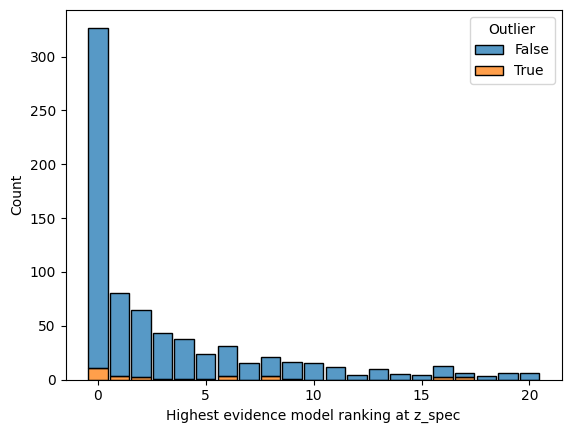

In [76]:
sub_df['Highest evidence model ranking at z_spec']=np.array(ranks_ev_at_zs)
sns.histplot(data=sub_df, x='Highest evidence model ranking at z_spec', hue='Outlier', discrete=True, binrange=(0,20), shrink=0.9, multiple='stack')

<AxesSubplot:ylabel='Count'>

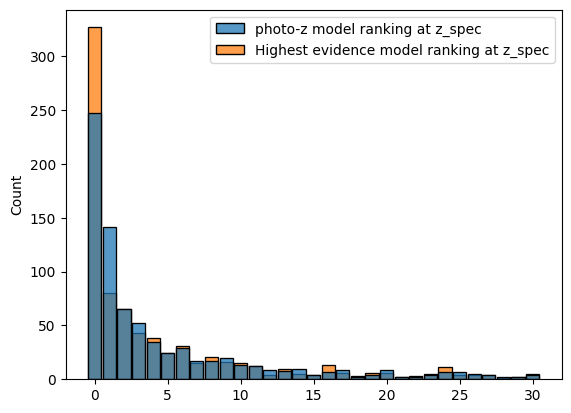

In [77]:
f,a=plt.subplots(1,1)
plot_df = sub_df[['photo-z model ranking at z_spec', 'Highest evidence model ranking at z_spec']].copy()
sns.histplot(data=plot_df, discrete=True, binrange=(0,30), shrink=0.9, multiple='dodge', ax=a, element='bars', cumulative=False)

/tmp/ipykernel_20313/3333230702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Ranking of best model at z_spec']=np.array(ranks)


<AxesSubplot:xlabel='Ranking of best model at z_spec', ylabel='Count'>

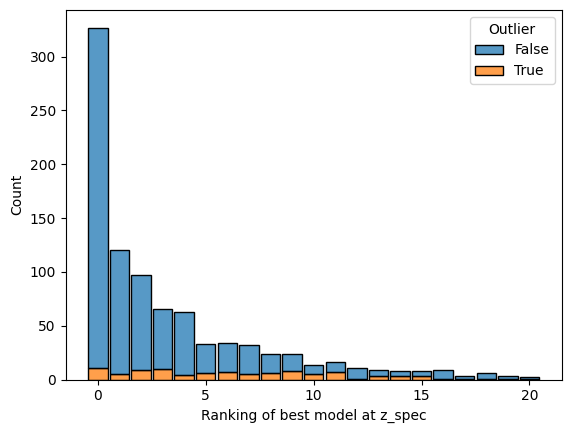

In [78]:
sub_df['Ranking of best model at z_spec']=np.array(ranks)
sns.histplot(data=sub_df, x='Ranking of best model at z_spec', hue='Outlier', discrete=True, binrange=(0,20), shrink=0.9, multiple='stack')

In [79]:
from pysankey import sankey

In [80]:
sub_df.columns

Index(['Id', 'Photometric redshift', 'True redshift', 'Template SED',
       'Extinction law', 'E(B-V)', 'Chi2', 'Highest evidence SED',
       'Highest evidence dust law', 'Highest evidence E(B-V)',
       'Highest evidence odd ratio', 'Highest evidence z_phot (mode)',
       'Highest evidence z_phot (mean)', 'Highest evidence sigma(z)',
       'Best SED at z_spec', 'Best dust law at z_spec', 'E(B-V) at z_spec',
       'Mode of best model at z_spec', 'Mean of best model at z_spec',
       'Odd ratio of best model at z_spec', 'MagAB(cosmos_u_cfht)',
       'err_MagAB(cosmos_u_cfht)', 'MagAB(cosmos_u_new)',
       'err_MagAB(cosmos_u_new)', 'MagAB(hsc_gHSC)', 'err_MagAB(hsc_gHSC)',
       'MagAB(hsc_rHSC)', 'err_MagAB(hsc_rHSC)', 'MagAB(hsc_iHSC)',
       'err_MagAB(hsc_iHSC)', 'MagAB(hsc_zHSC)', 'err_MagAB(hsc_zHSC)',
       'MagAB(hsc_yHSC)', 'err_MagAB(hsc_yHSC)', 'Bias', 'Outlier', 'U-B',
       'R-I', 'Best estimator', 'Best point estimate',
       'Best estimator at z_spec', 'Best

In [81]:
if True:
    _t1 = ["FORS2-"+t.split('-')[-1] for t in sub_df['Template SED'].values]
    _t2 = ["FORS2-"+t.split('-')[-1] for t in sub_df['Highest evidence SED'].values]
    _t3 = ["FORS2-"+t.split('-')[-1] for t in sub_df['Best SED at z_spec'].values]

    sub_df['Template SED'] = _t1
    sub_df['Highest evidence SED'] = _t2
    sub_df['Best SED at z_spec'] = _t3

/tmp/ipykernel_20313/1012285704.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Template SED'] = _t1
/tmp/ipykernel_20313/1012285704.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Highest evidence SED'] = _t2
/tmp/ipykernel_20313/1012285704.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

<AxesSubplot:>

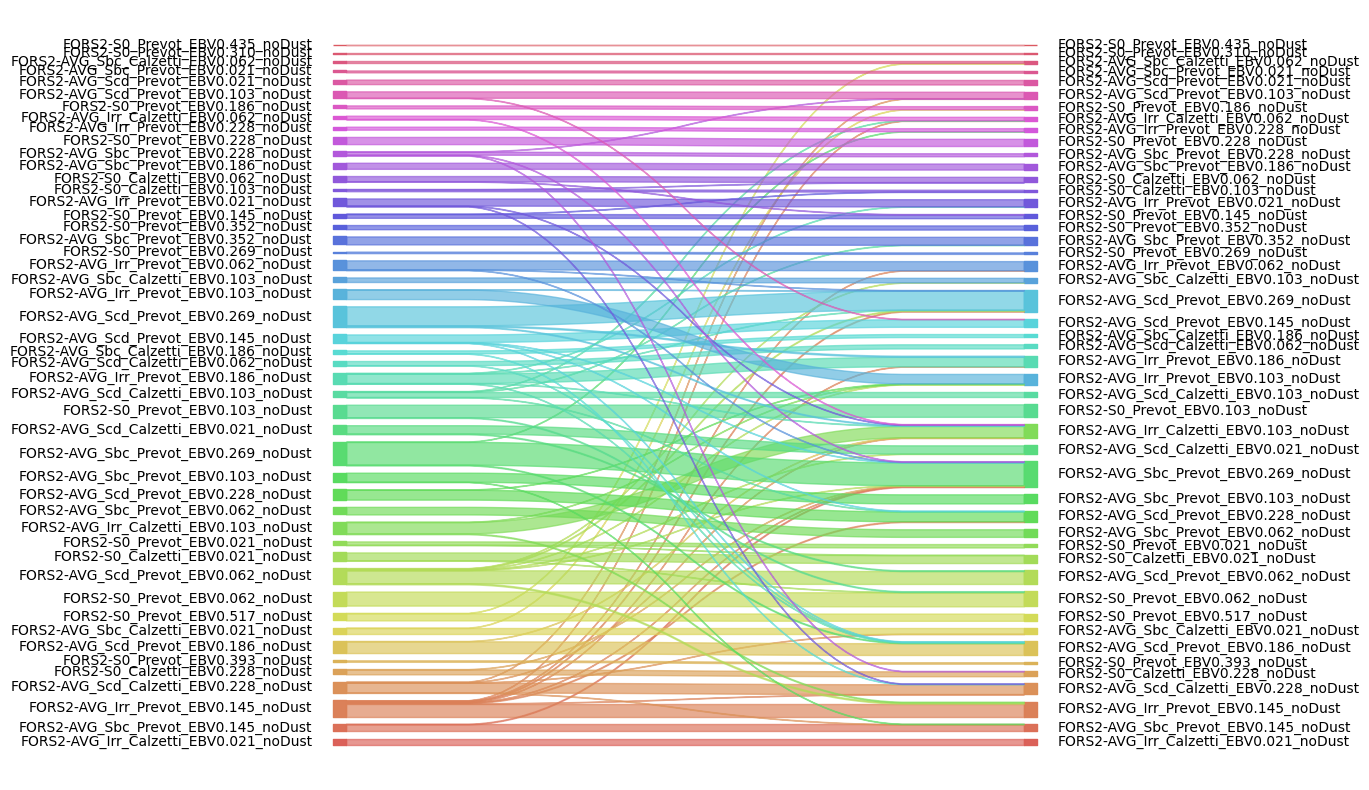

In [82]:
f,a = plt.subplots(1,1, figsize=(10,10))
sankey(sub_df['Template SED'], sub_df['Highest evidence SED'], fontsize=10, ax=a)

<AxesSubplot:>

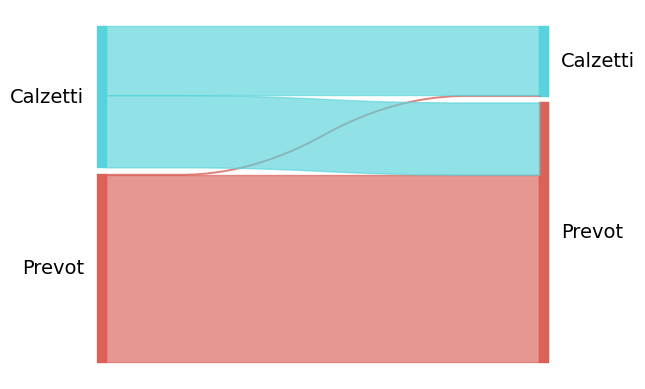

In [83]:
sankey(sub_df['Extinction law'], sub_df['Highest evidence dust law'])

<AxesSubplot:>

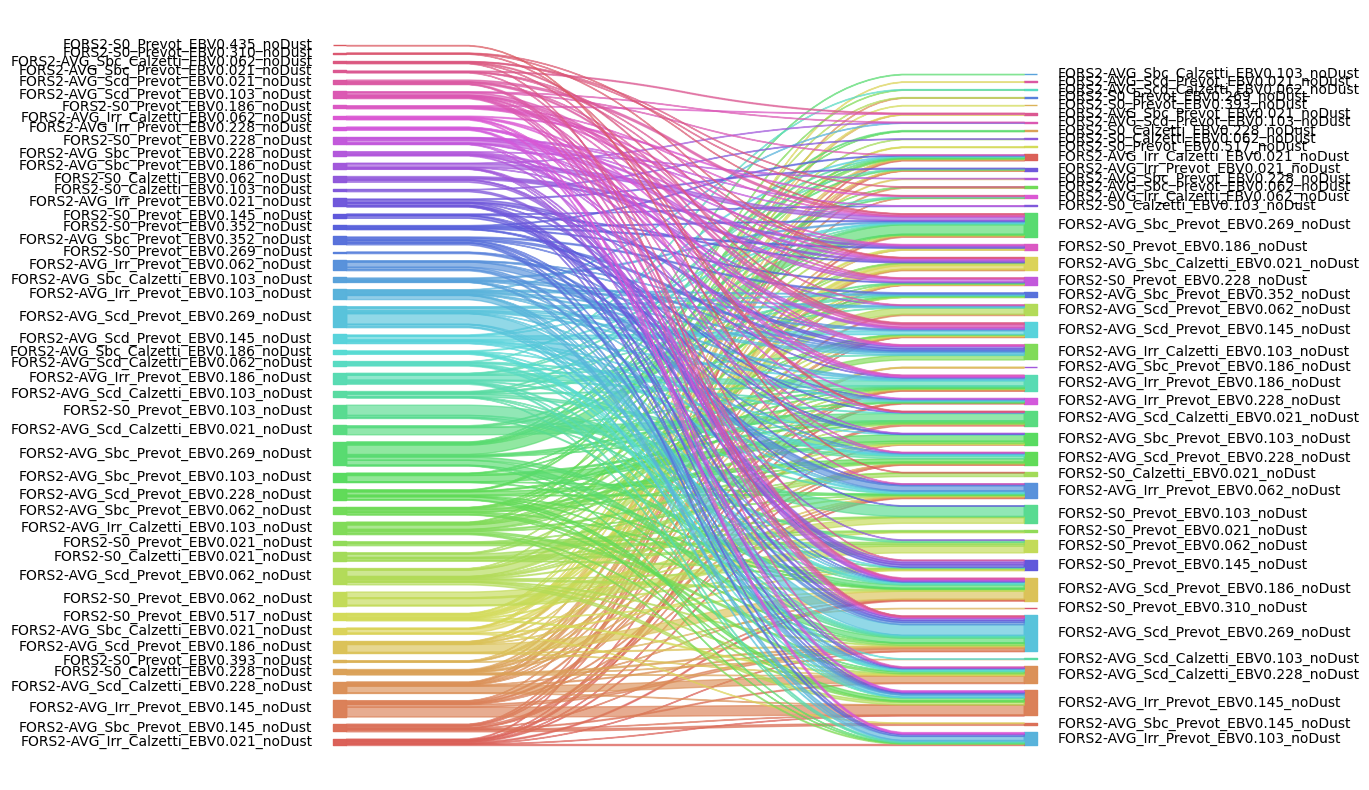

In [84]:
f,a = plt.subplots(1,1, figsize=(10,10))
sankey(sub_df['Template SED'], sub_df['Best SED at z_spec'], fontsize=10, ax=a)

<AxesSubplot:>

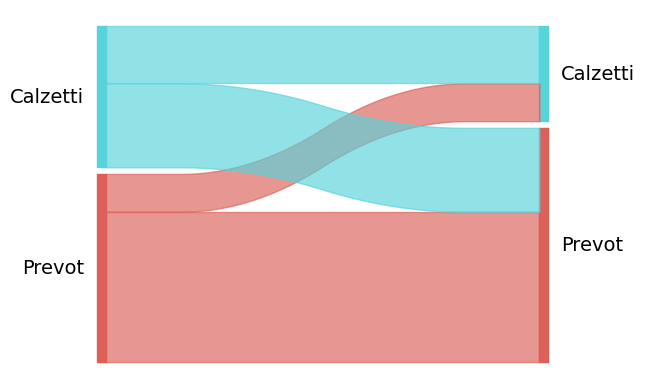

In [85]:
sankey(sub_df['Extinction law'], sub_df['Best dust law at z_spec'])

<AxesSubplot:>

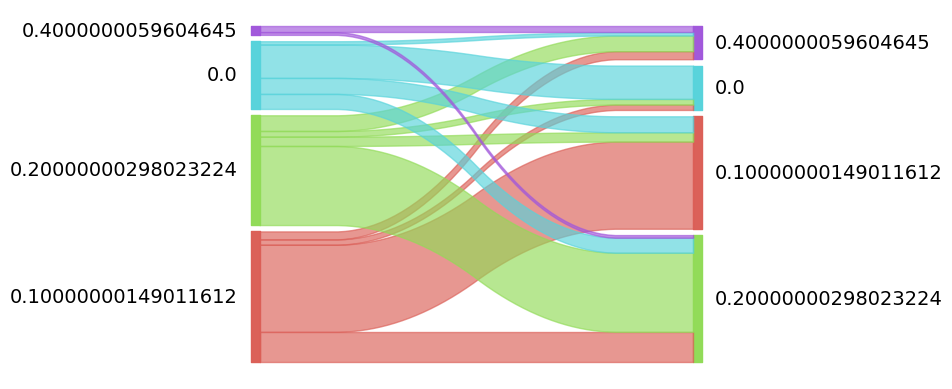

In [86]:
sankey(sub_df['E(B-V)'], sub_df['E(B-V) at z_spec'])

<AxesSubplot:>

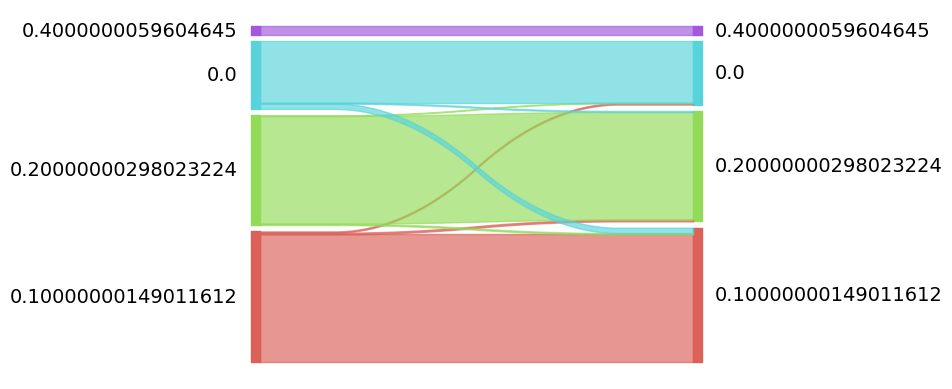

In [87]:
sankey(sub_df['E(B-V)'], sub_df['Highest evidence E(B-V)'])

<AxesSubplot:>

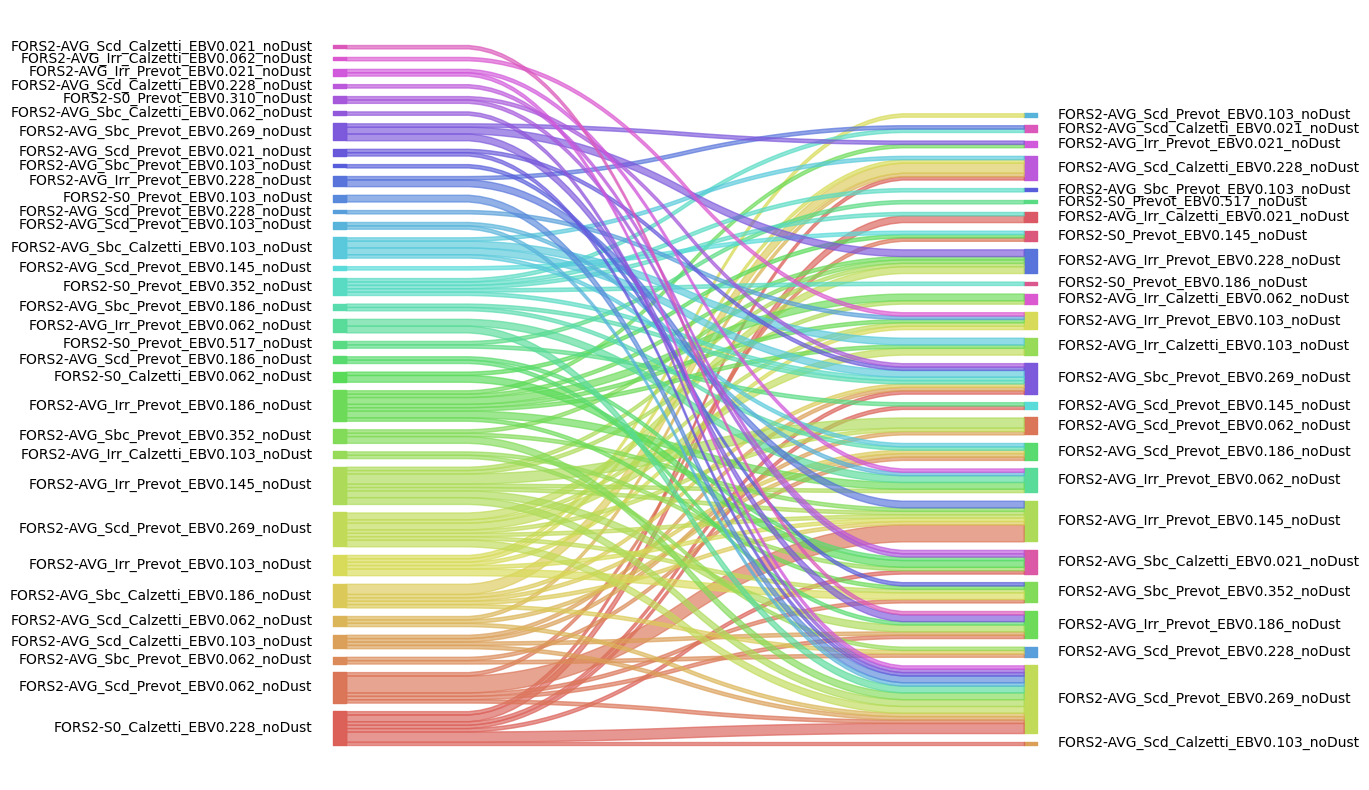

In [88]:
outliers_df = sub_df[sub_df['Outlier']]
f,a = plt.subplots(1,1, figsize=(10,10))
sankey(outliers_df['Template SED'], outliers_df['Best SED at z_spec'], fontsize=10, ax=a)

<AxesSubplot:>

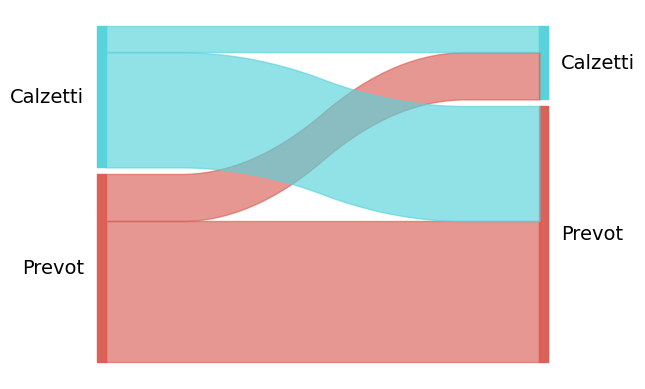

In [89]:
sankey(outliers_df['Extinction law'], outliers_df['Best dust law at z_spec'])

<AxesSubplot:>

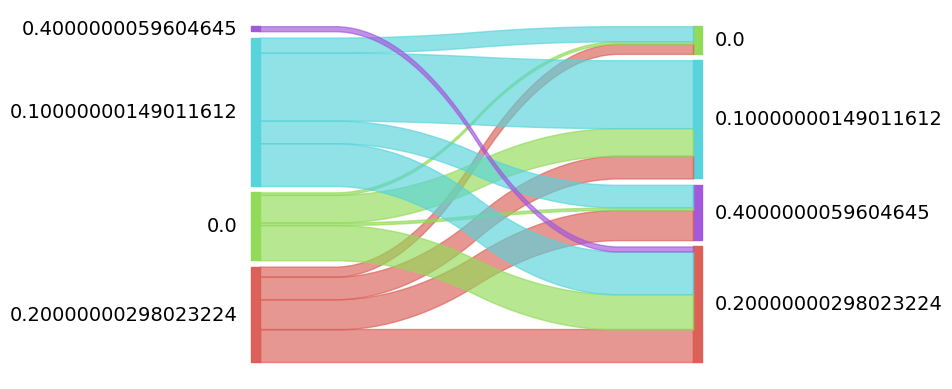

In [90]:
sankey(outliers_df['E(B-V)'], outliers_df['E(B-V) at z_spec'])

<AxesSubplot:>

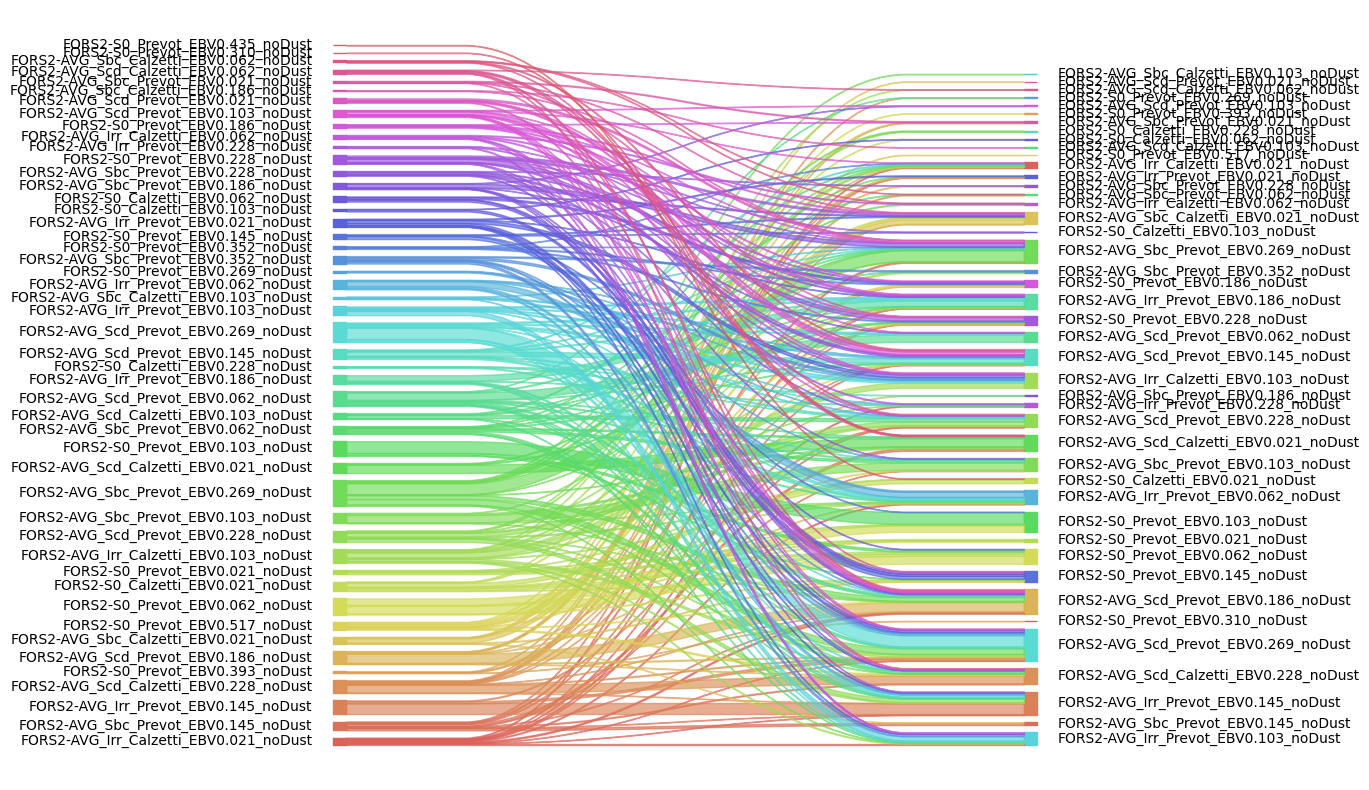

In [91]:
insiders_df = sub_df[[not b for b in sub_df['Outlier']]]
f,a = plt.subplots(1,1, figsize=(10,10))
sankey(insiders_df['Template SED'], insiders_df['Best SED at z_spec'], fontsize=10, ax=a)

<AxesSubplot:>

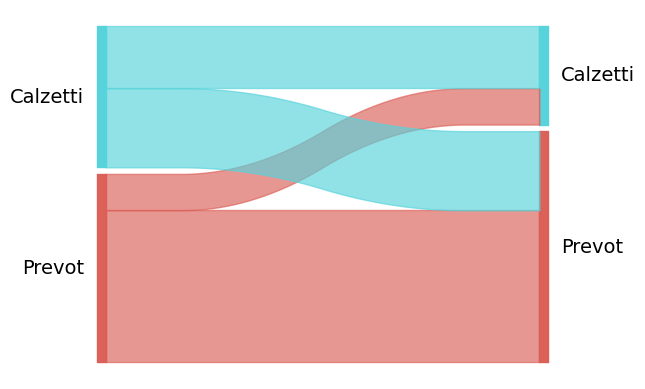

In [92]:
sankey(insiders_df['Extinction law'], insiders_df['Best dust law at z_spec'])

<AxesSubplot:>

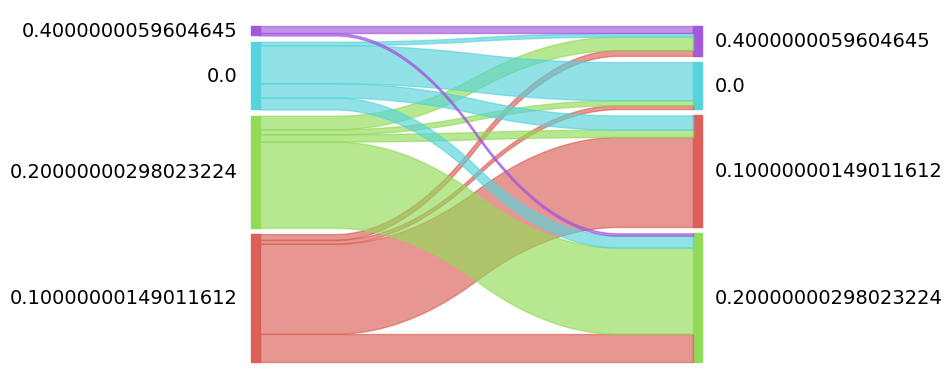

In [93]:
sankey(insiders_df['E(B-V)'], insiders_df['E(B-V) at z_spec'])

Pas de conclusion à propos de E(B-V) ni loi de poussière, par contre certaines templates peuvent être exclues par ce genre de procédé car très peu présentes dans les bons modèles à z_spec 